## 0. Setup

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt
import pprint

pt.update_plot_defaults()


# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:20000], shuffle=True, generator=data_generator)
full_train_dataloader = torch.utils.data.DataLoader(MNIST_train[0:50000], shuffle=True, generator=data_generator)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10000:], batch_size=10000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)
debug_dataloader = torch.utils.data.DataLoader(MNIST_train[0:6000])

epochs = 1
data_seed = 0
network_seed = 42

In [3]:
def diagnose_mnist_network(network, test_dataloader, train_sub_dataloader, val_dataloader, supervised=True, store_history=False, store_params=False, show_initial=False):
    
    if show_initial:
        title = 'Initial'
        pt.plot_batch_accuracy(network, test_dataloader, title=title)

        for layer in network:
            for population in layer:
                for projection in population:
                    plt.figure()
                    plt.imshow(projection.weight.data, aspect='auto', interpolation='none')
                    plt.suptitle('%s Weights: %s' % (title, projection.name))
                    plt.colorbar()

        for layer in network:
            for population in layer:
                plt.figure()
                plt.imshow(torch.atleast_2d(population.activity.detach().T), aspect='auto', interpolation='none')
                plt.suptitle('%s Activity: %s' % (title, population.fullname))
                plt.colorbar()
    
    network.train(train_sub_dataloader, val_dataloader, epochs=epochs, val_interval=(0, -1, 100), store_history=store_history, \
                  store_dynamics=True, store_params=store_params, status_bar=True)
    
    if not supervised:
        _, sorted_output_idx = ut.sort_by_val_history(network)
    else:
        sorted_output_idx = torch.arange(0, network.val_output_history.shape[-1])
    pt.plot_batch_accuracy(network, test_dataloader, sorted_output_idx=sorted_output_idx, title='Final')
    pt.plot_train_loss_history(network)
    pt.plot_validate_loss_history(network)
        
    title = 'Final'
    
    for layer in network:
        for population in layer:
            for projection in population:
                plt.figure()
                plt.imshow(projection.weight.data, aspect='auto', interpolation='none')
                plt.suptitle('%s Weights: %s' % (title, projection.name))
                plt.colorbar()
    
    for layer in network:
        for population in layer:
            plt.figure()
            plt.imshow(torch.atleast_2d(population.activity.detach().T), aspect='auto', interpolation='none')
            plt.suptitle('%s Activity: %s' % (title, population.fullname))
            plt.colorbar()
    
    plt.show()

In [4]:
def analyze_BTSP_intermediates(btsp_network):

    fig, axes = plt.subplots(4, 2, figsize=(10., 12.))

    im = axes[0][0].imshow(btsp_network.H1.E.plateau_history.T, aspect='auto', interpolation='none')
    plt.colorbar(im, ax=axes[0][0])
    axes[0][0].set_title('Plateau history: H1.E')
    axes[0][0].set_ylabel('Unit ID')
    axes[0][0].set_xlabel('Training steps')

    im = axes[0][1].imshow(btsp_network.Output.E.plateau_history.T, aspect='auto', interpolation='none')
    plt.colorbar(im, ax=axes[0][1])
    axes[0][1].set_title('Plateau history: Output.E')
    axes[0][1].set_xlabel('Training steps')

    binned_Output_E_plateau_prob = btsp_network.Output.E.plateau_history.T.reshape(btsp_network.Output.E.plateau_history.T.shape[0], -1, 100).mean(dim=(0,2))
    binned_H1_E_plateau_prob = btsp_network.H1.E.plateau_history.T.reshape(btsp_network.H1.E.plateau_history.T.shape[0], -1, 100).mean(dim=(0,2))
    binned_train_steps = torch.arange(1, len(binned_H1_E_plateau_prob) + 1) * 100

    axes[1][0].plot(binned_train_steps, binned_H1_E_plateau_prob)
    axes[1][1].plot(binned_train_steps, binned_Output_E_plateau_prob)
    axes[1][0].set_ylabel('Mean plateau amp')
    axes[1][0].set_xlabel('Training steps')
    axes[1][1].set_xlabel('Training steps')
    axes[1][0].set_title('Plateau_history: H1.E')
    axes[1][1].set_title('Plateau_history: Output.E')

    if isinstance(btsp_network.H1.E.forward_dendritic_state_history,  list):
        btsp_network.H1.E.forward_dendritic_state_history = torch.stack(btsp_network.H1.E.forward_dendritic_state_history)
    if isinstance(btsp_network.H1.E.backward_dendritic_state_history,  list):
        btsp_network.H1.E.backward_dendritic_state_history = torch.stack(btsp_network.H1.E.backward_dendritic_state_history)

    binned_H1_E_forward_dend_state = btsp_network.H1.E.forward_dendritic_state_history.T.reshape(btsp_network.H1.E.forward_dendritic_state_history.T.shape[0], -1, 100).mean(dim=(0,2))
    binned_H1_E_backward_dend_state = btsp_network.H1.E.backward_dendritic_state_history.T.reshape(btsp_network.H1.E.backward_dendritic_state_history.T.shape[0], -1, 100).mean(dim=(0,2))

    axes[2][0].plot(binned_train_steps, binned_H1_E_forward_dend_state)
    axes[2][0].set_title('Forward dendritic state: H1.E')
    axes[2][0].set_xlabel('Training steps')
    axes[2][0].set_ylabel('Mean amplitude')

    axes[2][1].plot(binned_train_steps, binned_H1_E_backward_dend_state)
    axes[2][1].set_title('Backward dendritic state: H1.E')
    axes[2][1].set_xlabel('Training steps')
    axes[3][0].plot(btsp_network.param_history_steps, torch.mean(btsp_network.H1.E.H1.DendI.weight_history, dim=(1,2)))
    axes[3][0].set_title('Weight history: H1.E.H1.DendI')
    axes[3][0].set_xlabel('Training steps')
    axes[3][0].set_ylabel('Mean weight')

    axes[3][1].plot(btsp_network.param_history_steps, torch.mean(btsp_network.H1.E.Output.E.weight_history, dim=(1,2)))
    axes[3][1].set_title('Weight history: H1.E.Output.E')
    axes[3][1].set_xlabel('Training steps')
    axes[3][1].set_ylabel('Mean weight')

    fig.tight_layout()
    fig.show()

### Backprop (no weight contraints)

In [ ]:
# Create network
network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_relu_SGD_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
data_generator.manual_seed(data_seed)
diagnose_mnist_network(bp_network, test_dataloader, train_sub_dataloader, val_dataloader, supervised=True)

### Backprop (Dale's Law)

In [ ]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/20230102_EIANN_1_hidden_mnist_bpDale_softplus_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bpDale_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
data_generator.manual_seed(data_seed)
diagnose_mnist_network(bpDale_network, test_dataloader, train_sub_dataloader, val_dataloader, supervised=True, store_history=True)

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(12,4))

t = 0
hidden_activity = torch.mean(bpDale_network.H1.E.activity_history[t], dim=1)
output_activity = torch.mean(bpDale_network.Output.E.activity_history[t], dim=1)
ax[0,0].plot(hidden_activity,'--',color='r', label='H1E')
ax[0,0].plot(output_activity,color='r', label='OutputE')
ax[0,0].set_title('Before training')
ax[0,0].legend()

hiddenFBI_activity = torch.mean(bpDale_network.H1.FBI.activity_history[t], dim=1)
outputFBI_activity = torch.mean(bpDale_network.Output.FBI.activity_history[t], dim=1)
ax[1,0].plot(hiddenFBI_activity,'--',color='b', label='H1FBI')
ax[1,0].plot(outputFBI_activity,color='b', label='OutputFBI')


t = -1
hidden_activity = torch.mean(bpDale_network.H1.E.activity_history[t], dim=1)
output_activity = torch.mean(bpDale_network.Output.E.activity_history[t], dim=1)
ax[0,1].plot(hidden_activity,'--',color='r', label='H1E')
ax[0,1].plot(output_activity,color='r', label='OutputE')
ax[0,1].set_title('After training')
ax[0,1].legend()

hiddenFBI_activity = torch.mean(bpDale_network.H1.FBI.activity_history[t], dim=1)
outputFBI_activity = torch.mean(bpDale_network.Output.FBI.activity_history[t], dim=1)
ax[1,1].plot(hiddenFBI_activity,'--',color='b', label='H1FBI')
ax[1,1].plot(outputFBI_activity,color='b', label='OutputFBI')

plt.show()

### Backprop (Dale's Law) - 1 mixed FF/FB Inh

In [ ]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/20230126_EIANN_1_hidden_mnist_bpDale_softplus_1_inh_C.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bpDale_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
data_generator.manual_seed(data_seed)
diagnose_mnist_network(bpDale_network, test_dataloader, train_sub_dataloader, val_dataloader, supervised=True)

## BTSP_D1
static H1.FBI, static Output.FBI, H1.E.H1.Dend_I learned w/ Dendritic_Loss_3

In [ ]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/MNIST/20230220_1_hidden_mnist_BTSP_D1.yaml') 
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
data_generator.manual_seed(data_seed)
diagnose_mnist_network(btsp_network, test_dataloader, train_sub_dataloader, val_dataloader, supervised=True)

## BTSP_E
H1.FBI, Output.FBI, and H1.Dend_I learned w/ Gjorgjieva-Hebb

In [ ]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/20221227_EIANN_1_hidden_mnist_BTSP_config_E.yaml') 
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
data_generator.manual_seed(data_seed)
diagnose_mnist_network(btsp_network, test_dataloader, train_sub_dataloader, supervised=True, store_history=True)

In [ ]:
plt.figure()
plt.imshow(btsp_network.Output.E.plateau_history.T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.plot(torch.mean(btsp_network.Output.E.plateau_history, dim=1))
plt.show()

plt.figure()
plt.plot(torch.mean(btsp_network.Output.E.activity_history[:,-1,:], dim=1))
plt.show()

plt.figure()
plt.imshow(btsp_network.H1.E.plateau_history.T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.plot(torch.mean(btsp_network.H1.E.plateau_history, dim=1))
plt.show()

plt.figure()
plt.plot(torch.mean(btsp_network.H1.E.activity_history[:,-1,:], dim=1))
plt.show()

In [ ]:
plt.figure()
plt.imshow(btsp_network.H1.Dend_I.H1.Dend_I.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

In [ ]:
plt.figure()
plt.imshow(btsp_network.H1.E.H1.Dend_I.weight.data, aspect='auto', interpolation='none')
plt.colorbar()

## BTSP_F1
H1.Soma_I and Output.Soma_I receive both bottom-up and lateral input, learned w/ Gjorgjieva_Hebb_2<br>
H1.Dend_I receives inputs cloned from H1.Soma_I. H1.E.H1.Dend_I projection to dendritic compartment is learned with Dendritic_Loss_3.

In [ ]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/mnist/20230705_EIANN_1_hidden_mnist_BTSP_config_F1.yaml') 
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network_F1 = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
data_generator.manual_seed(data_seed)
diagnose_mnist_network(btsp_network_F1, test_dataloader, train_sub_dataloader, val_dataloader, supervised=True, store_history=True, store_params=True)
# diagnose_mnist_network(btsp_network_F1, test_dataloader, debug_dataloader, val_dataloader, supervised=True, store_history=True, store_params=True)

In [ ]:
btsp_network = btsp_network_F1
fig, axes = plt.subplots(4, 2, figsize=(10., 12.))

im = axes[0][0].imshow(btsp_network.H1.E.plateau_history.T, aspect='auto', interpolation='none', cmap='RdBu_r')
plt.colorbar(im, ax=axes[0][0])
axes[0][0].set_title('Plateau history: H1.E')
axes[0][0].set_ylabel('Unit ID')
axes[0][0].set_xlabel('Training steps')

im = axes[0][1].imshow(btsp_network.Output.E.plateau_history.T, aspect='auto', interpolation='none', cmap='RdBu_r')
plt.colorbar(im, ax=axes[0][1])
axes[0][1].set_title('Plateau history: Output.E')
axes[0][1].set_xlabel('Training steps')

binned_Output_E_plateau_prob = btsp_network.Output.E.plateau_history.T.reshape(btsp_network.Output.E.plateau_history.T.shape[0], -1, 100).mean(dim=(0,2))
binned_H1_E_plateau_prob = btsp_network.H1.E.plateau_history.T.reshape(btsp_network.H1.E.plateau_history.T.shape[0], -1, 100).mean(dim=(0,2))
binned_train_steps = torch.arange(1, len(binned_H1_E_plateau_prob) + 1) * 100

axes[1][0].plot(binned_train_steps, binned_H1_E_plateau_prob)
axes[1][1].plot(binned_train_steps, binned_Output_E_plateau_prob)
axes[1][0].set_ylabel('Mean plateau amp')
axes[1][0].set_xlabel('Training steps')
axes[1][1].set_xlabel('Training steps')
axes[1][0].set_title('Plateau_history: H1.E')
axes[1][1].set_title('Plateau_history: Output.E')

if isinstance(btsp_network.H1.E.forward_dendritic_state_history,  list):
    btsp_network.H1.E.forward_dendritic_state_history = torch.stack(btsp_network.H1.E.forward_dendritic_state_history)
if isinstance(btsp_network.H1.E.backward_dendritic_state_history,  list):
    btsp_network.H1.E.backward_dendritic_state_history = torch.stack(btsp_network.H1.E.backward_dendritic_state_history)

binned_H1_E_forward_dend_state = btsp_network.H1.E.forward_dendritic_state_history.T.reshape(btsp_network.H1.E.forward_dendritic_state_history.T.shape[0], -1, 100).mean(dim=(0,2))
binned_H1_E_backward_dend_state = btsp_network.H1.E.backward_dendritic_state_history.T.reshape(btsp_network.H1.E.backward_dendritic_state_history.T.shape[0], -1, 100).mean(dim=(0,2))
    
axes[2][0].plot(binned_train_steps, binned_H1_E_forward_dend_state)
axes[2][0].set_title('Forward dendritic state: H1.E')
axes[2][0].set_xlabel('Training steps')
axes[2][0].set_ylabel('Mean amplitude')

axes[2][1].plot(binned_train_steps, binned_H1_E_backward_dend_state)
axes[2][1].set_title('Backward dendritic state: H1.E')
axes[2][1].set_xlabel('Training steps')

axes[3][0].plot(btsp_network.param_history_steps, torch.mean(btsp_network.H1.E.H1.DendI.weight_history, dim=(1,2)))
axes[3][0].set_title('Weight history: H1.E.H1.DendI')
axes[3][0].set_xlabel('Training steps')
axes[3][0].set_ylabel('Mean weight')

axes[3][1].plot(btsp_network.param_history_steps, torch.mean(btsp_network.H1.E.Output.E.weight_history, dim=(1,2)))
axes[3][1].set_title('Weight history: H1.E.Output.E')
axes[3][1].set_xlabel('Training steps')
axes[3][1].set_ylabel('Mean weight')

fig.tight_layout()
fig.show()
plt.show()

In [ ]:
plt.figure()
combined_average_dynamics = torch.concat([
    torch.mean(btsp_network.H1.DendI.activity_history, dim=0),
    torch.mean(btsp_network.H1.DendI.backward_activity_history, dim=0)
], dim=0)
plt.imshow(combined_average_dynamics.T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
index = 0
plt.figure()
combined_average_dynamics = torch.concat([
    btsp_network.H1.DendI.activity_history[index,:,:],
    btsp_network.H1.DendI.backward_activity_history[index,:,:]
], dim=0)
#plt.imshow(combined_average_dynamics.T, aspect='auto', interpolation='none')
#plt.colorbar()
plt.plot(torch.mean(combined_average_dynamics, dim=1))
plt.show()

In [ ]:
index = -1
plt.figure()
combined_average_dynamics = torch.concat([
    btsp_network.Output.E.activity_history[index,:,:],
    btsp_network.Output.E.backward_activity_history[index,:,:]
], dim=0)
plt.imshow(combined_average_dynamics.T, aspect='auto', interpolation='none')
plt.colorbar()
#plt.plot(torch.mean(combined_average_dynamics, dim=1))
plt.show()

## BTSP_F2

In [ ]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/mnist/20230705_EIANN_1_hidden_mnist_BTSP_config_F2.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network_F2 = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
data_generator.manual_seed(data_seed)
# diagnose_mnist_network(btsp_network_F2, test_dataloader, train_sub_dataloader, val_dataloader, supervised=True, store_history=True, store_params=True)
diagnose_mnist_network(btsp_network_F2, test_dataloader, debug_dataloader, val_dataloader, supervised=True, store_history=True, store_params=True)

In [ ]:
btsp_network = btsp_network_F2

fig, axes = plt.subplots(4, 2, figsize=(10., 12.))

im = axes[0][0].imshow(btsp_network.H1.E.plateau_history.T, aspect='auto', interpolation='none')
plt.colorbar(im, ax=axes[0][0])
axes[0][0].set_title('Plateau history: H1.E')
axes[0][0].set_ylabel('Unit ID')
axes[0][0].set_xlabel('Training steps')

im = axes[0][1].imshow(btsp_network.Output.E.plateau_history.T, aspect='auto', interpolation='none')
plt.colorbar(im, ax=axes[0][1])
axes[0][1].set_title('Plateau history: Output.E')
axes[0][1].set_xlabel('Training steps')

binned_Output_E_plateau_prob = btsp_network.Output.E.plateau_history.T.reshape(btsp_network.Output.E.plateau_history.T.shape[0], -1, 100).mean(dim=(0,2))
binned_H1_E_plateau_prob = btsp_network.H1.E.plateau_history.T.reshape(btsp_network.H1.E.plateau_history.T.shape[0], -1, 100).mean(dim=(0,2))
binned_train_steps = torch.arange(1, len(binned_H1_E_plateau_prob) + 1) * 100

axes[1][0].plot(binned_train_steps, binned_H1_E_plateau_prob)
axes[1][1].plot(binned_train_steps, binned_Output_E_plateau_prob)
axes[1][0].set_ylabel('Mean plateau amp')
axes[1][0].set_xlabel('Training steps')
axes[1][1].set_xlabel('Training steps')
axes[1][0].set_title('Plateau_history: H1.E')
axes[1][1].set_title('Plateau_history: Output.E')

if isinstance(btsp_network.H1.E.forward_dendritic_state_history,  list):
    btsp_network.H1.E.forward_dendritic_state_history = torch.stack(btsp_network.H1.E.forward_dendritic_state_history)
if isinstance(btsp_network.H1.E.backward_dendritic_state_history,  list):
    btsp_network.H1.E.backward_dendritic_state_history = torch.stack(btsp_network.H1.E.backward_dendritic_state_history)

binned_H1_E_forward_dend_state = btsp_network.H1.E.forward_dendritic_state_history.T.reshape(btsp_network.H1.E.forward_dendritic_state_history.T.shape[0], -1, 100).mean(dim=(0,2))
binned_H1_E_backward_dend_state = btsp_network.H1.E.backward_dendritic_state_history.T.reshape(btsp_network.H1.E.backward_dendritic_state_history.T.shape[0], -1, 100).mean(dim=(0,2))
    
axes[2][0].plot(binned_train_steps, binned_H1_E_forward_dend_state)
axes[2][0].set_title('Forward dendritic state: H1.E')
axes[2][0].set_xlabel('Training steps')
axes[2][0].set_ylabel('Mean amplitude')

axes[2][1].plot(binned_train_steps, binned_H1_E_backward_dend_state)
axes[2][1].set_title('Backward dendritic state: H1.E')
axes[2][1].set_xlabel('Training steps')
axes[3][0].plot(btsp_network.param_history_steps, torch.mean(btsp_network.H1.E.H1.DendI.weight_history, dim=(1,2)))
axes[3][0].set_title('Weight history: H1.E.H1.DendI')
axes[3][0].set_xlabel('Training steps')
axes[3][0].set_ylabel('Mean weight')

axes[3][1].plot(btsp_network.param_history_steps, torch.mean(btsp_network.H1.E.Output.E.weight_history, dim=(1,2)))
axes[3][1].set_title('Weight history: H1.E.Output.E')
axes[3][1].set_xlabel('Training steps')
axes[3][1].set_ylabel('Mean weight')

fig.tight_layout()
fig.show()
plt.show()

In [ ]:
btsp_network.H1.E.backward_dendritic_state_history.shape

## BTSP_F3

In [ ]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/mnist/20230714_EIANN_1_hidden_mnist_BTSP_config_F3.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network_F3 = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
data_generator.manual_seed(data_seed)
diagnose_mnist_network(btsp_network_F3, test_dataloader, full_train_dataloader, val_dataloader, supervised=True, store_history=True, store_params=True)
# diagnose_mnist_network(btsp_network_F3, test_dataloader, train_sub_dataloader, val_dataloader, supervised=True, store_history=True, store_params=True)
# diagnose_mnist_network(btsp_network_F3, test_dataloader, debug_dataloader, val_dataloader, supervised=True, store_history=True, store_params=True)

In [ ]:
analyze_BTSP_intermediates(btsp_network_F3)

In [ ]:
btsp_network.Output.E.plateau_history.shape

In [ ]:
btsp_network.H1.E.forward_dendritic_state_history.shape

In [ ]:
btsp_network.H1.E.backward_dendritic_state_history.shape

In [ ]:
torch.stack(btsp_network.Output.E.forward_dendritic_state_history).shape

In [ ]:
torch.stack(btsp_network.Output.E.backward_dendritic_state_history).shape

In [ ]:
print(btsp_network.forward_steps)

In [ ]:
index = 0
plt.figure()
combined_average_dynamics = torch.concat([
    btsp_network.H1.E.activity_history[index,:,:],
    btsp_network.H1.E.backward_activity_history[index,:,:]
], dim=0)
plt.imshow(combined_average_dynamics.T, aspect='auto', interpolation='none')
plt.colorbar()
#plt.plot(torch.mean(combined_average_dynamics, dim=1))
plt.show()

In [ ]:
index = 0
plt.figure()
combined_average_dynamics = torch.concat([
    btsp_network.H1.DendI.activity_history[index,:,:],
    btsp_network.H1.DendI.backward_activity_history[index,:,:]
], dim=0)
#plt.imshow(combined_average_dynamics.T, aspect='auto', interpolation='none')
#plt.colorbar()
plt.plot(torch.mean(combined_average_dynamics, dim=1))
plt.show()

In [ ]:
plt.figure()
plt.imshow(torch.stack(btsp_network_F3.output_pop.IS_history).T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
plt.figure()
plt.imshow(torch.stack(btsp_network_F3.H1.E.ET_history).T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
plt.figure()
plt.imshow(btsp_network_F3.H1.E.backward_activity_history[-1].T, aspect='auto', interpolation='none')

## BTSP_F4

In [ ]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/mnist/20230712_EIANN_1_hidden_mnist_BTSP_config_F4.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network_F4 = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
data_generator.manual_seed(data_seed)
diagnose_mnist_network(btsp_network_F4, test_dataloader, train_sub_dataloader, val_dataloader, supervised=True, store_history=True, store_params=True)
# diagnose_mnist_network(btsp_network_F4, test_dataloader, debug_dataloader, val_dataloader, supervised=True, store_history=True, store_params=True)

In [ ]:
analyze_BTSP_intermediates(btsp_network_F4)

In [ ]:
index = -1
plt.figure()
combined_average_dynamics = torch.concat([
    btsp_network.H1.E.activity_history[index,:,:],
    btsp_network.H1.E.backward_activity_history[index,:,:]
], dim=0)
plt.imshow(combined_average_dynamics.T, aspect='auto', interpolation='none')
plt.colorbar()
#plt.plot(torch.mean(combined_average_dynamics, dim=1))
plt.show()

## BTSP_F5

In [7]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/mnist/20230718_EIANN_1_hidden_mnist_BTSP_config_F5_optimized.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network_F5 = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/20000 [00:00<?, ?it/s]

Batch accuracy = 84.33000183105469%


<IPython.core.display.Javascript object>


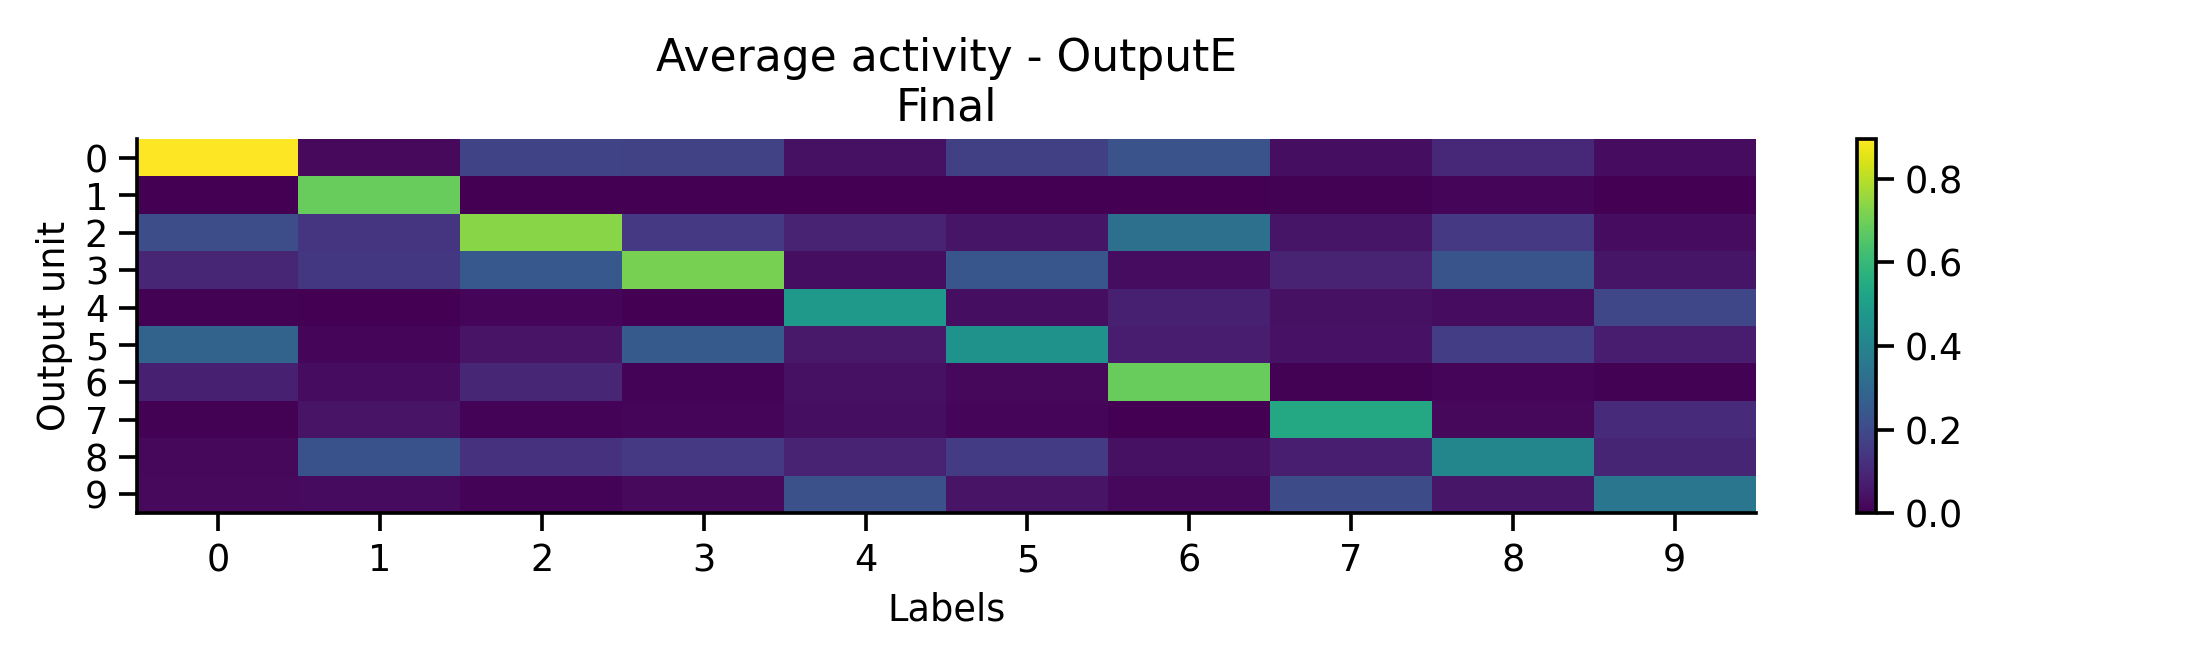

<IPython.core.display.Javascript object>


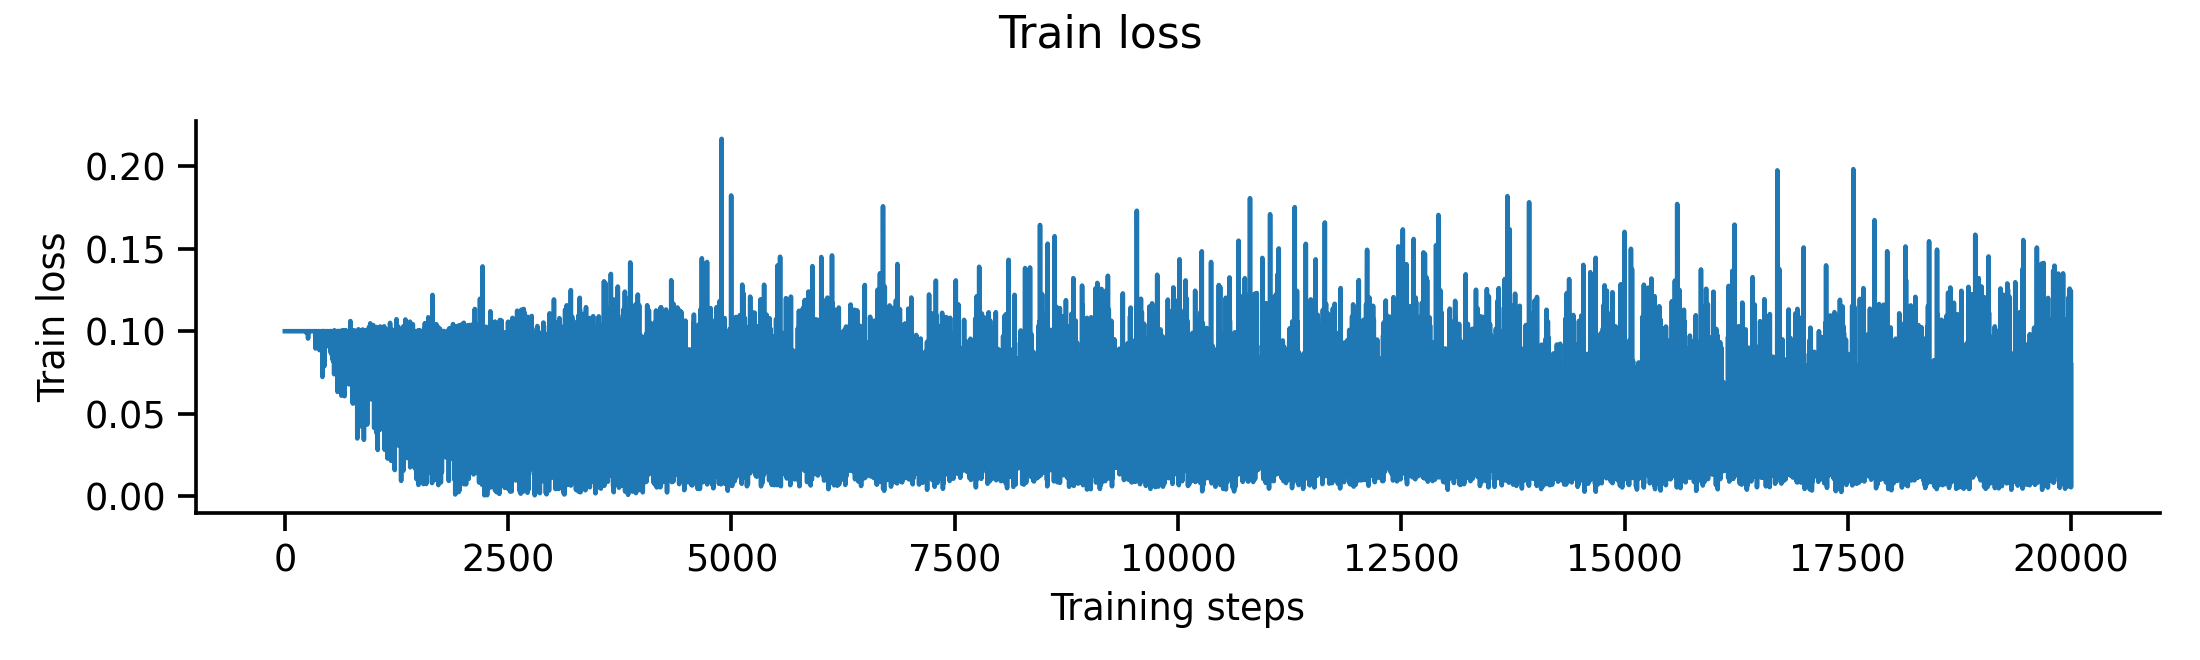

<IPython.core.display.Javascript object>


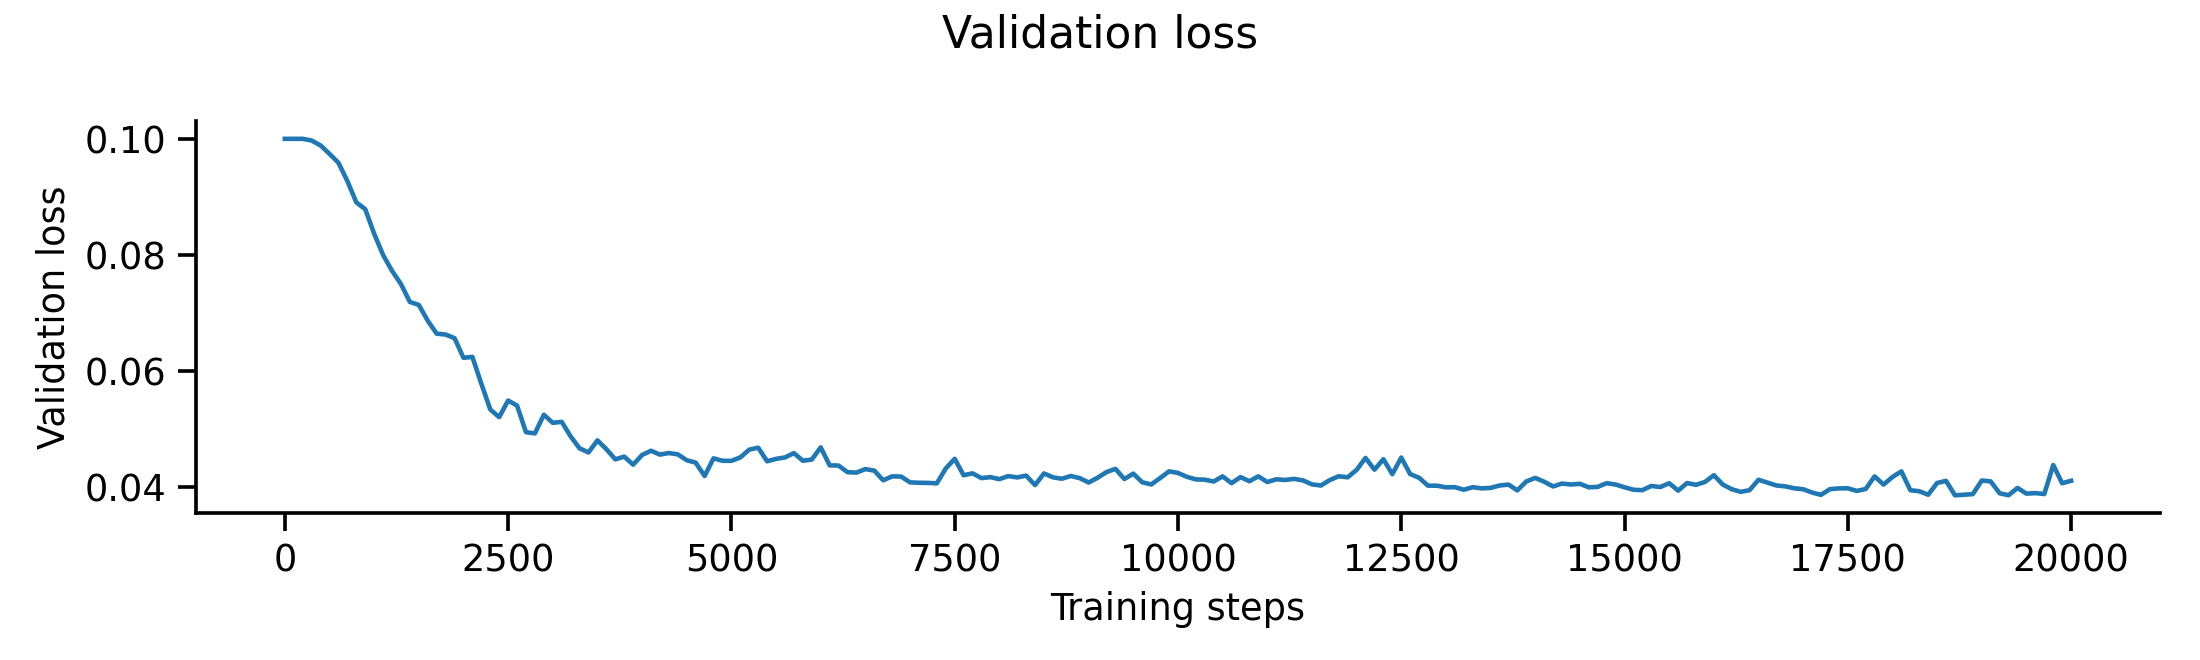

<IPython.core.display.Javascript object>


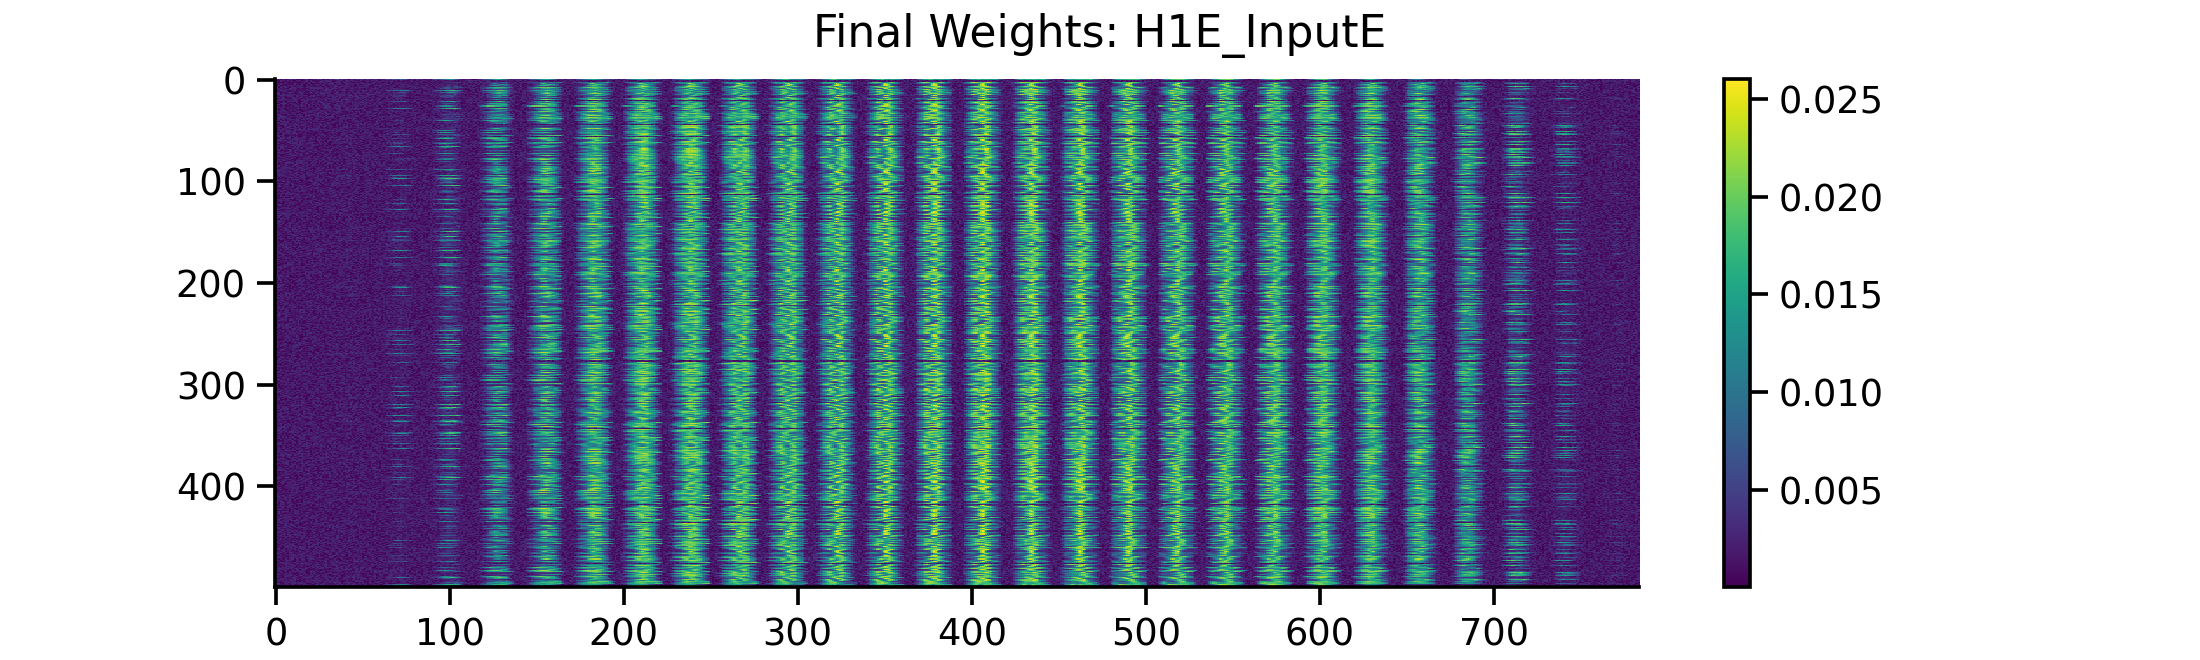

<IPython.core.display.Javascript object>


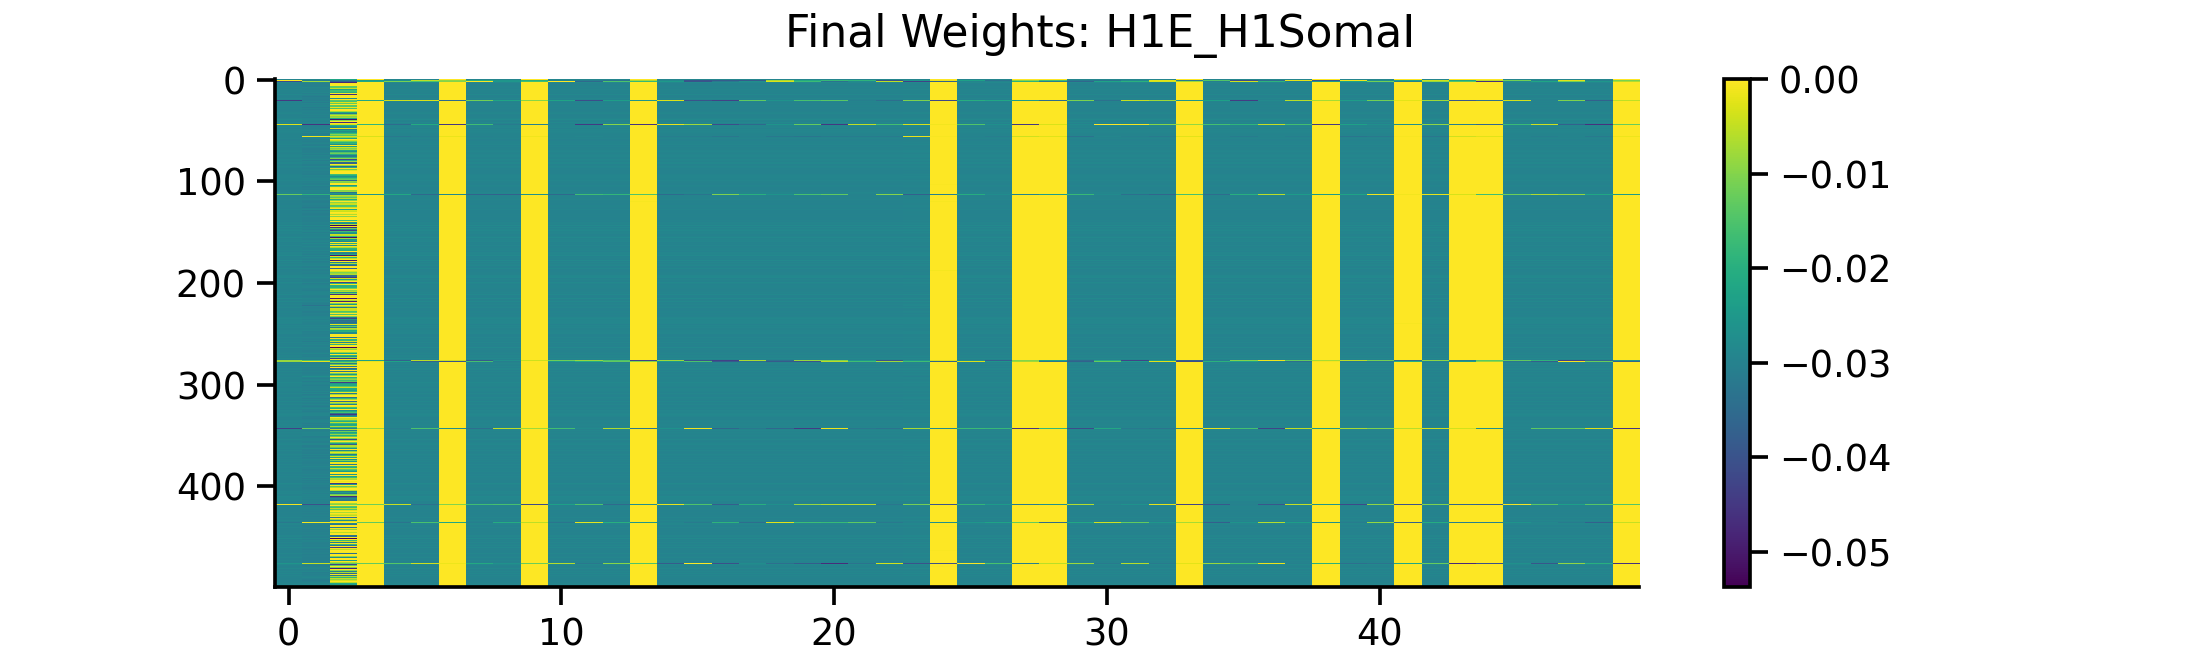

<IPython.core.display.Javascript object>


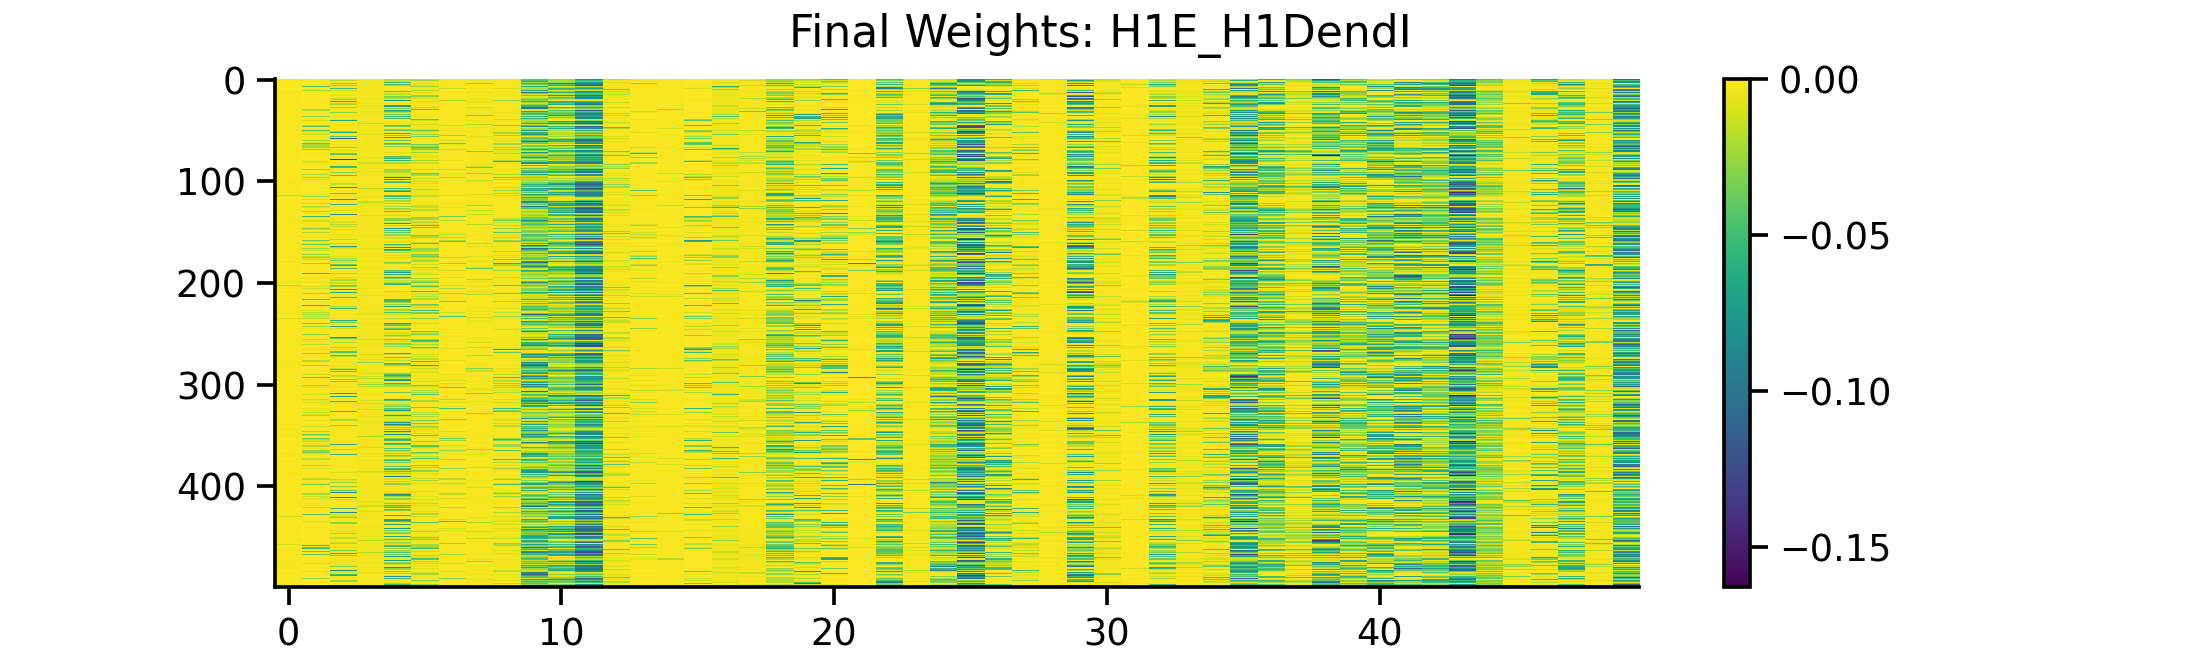

<IPython.core.display.Javascript object>


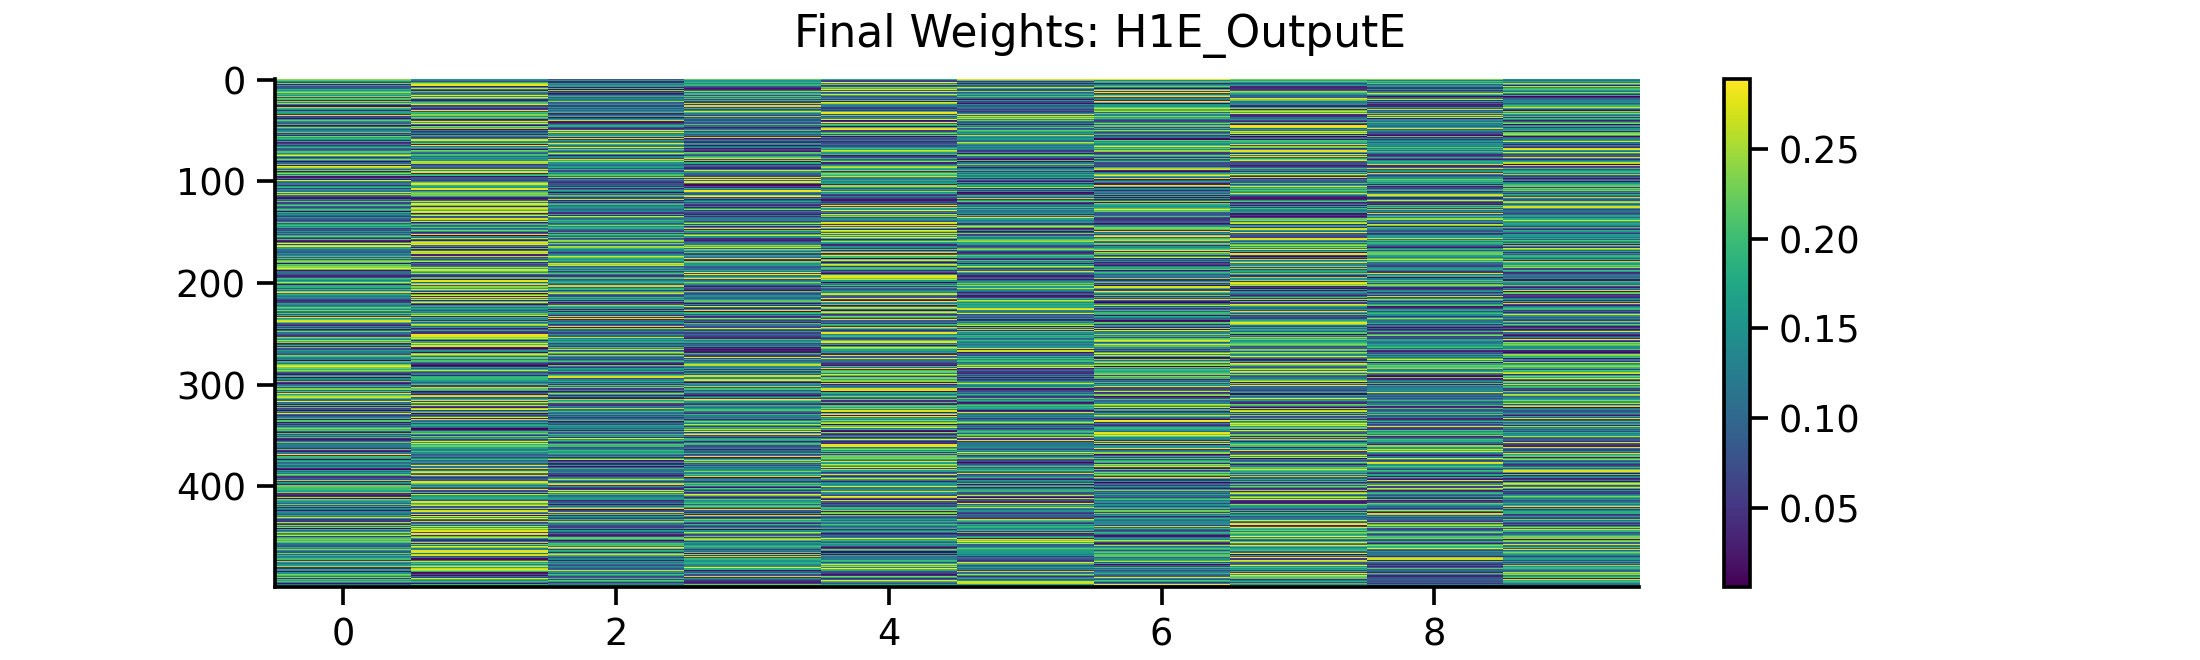

<IPython.core.display.Javascript object>


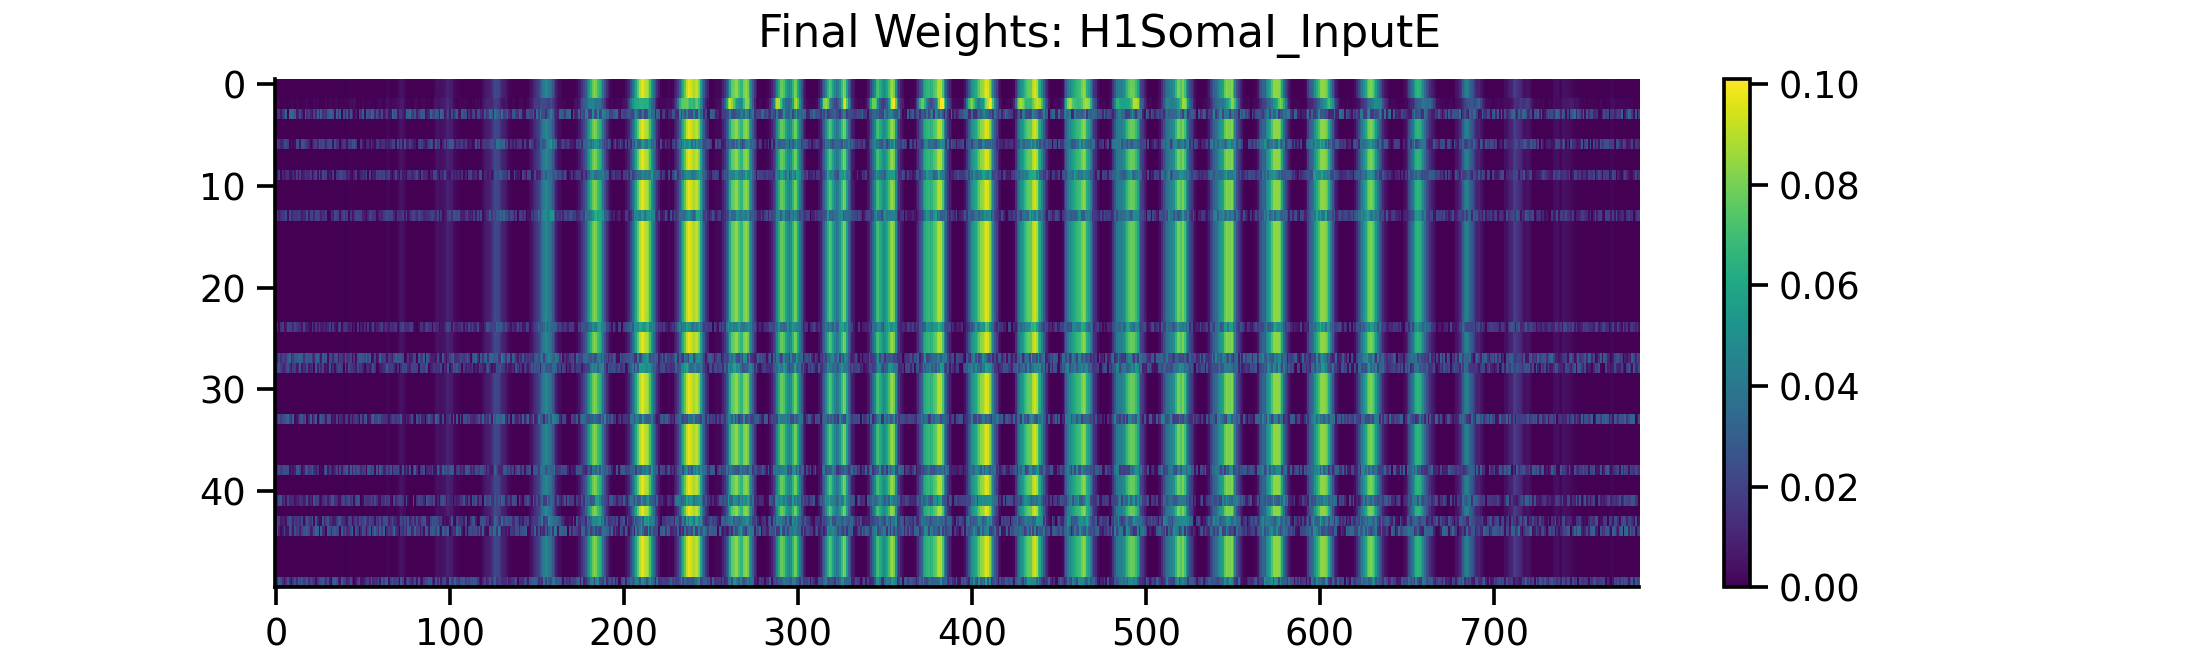

<IPython.core.display.Javascript object>


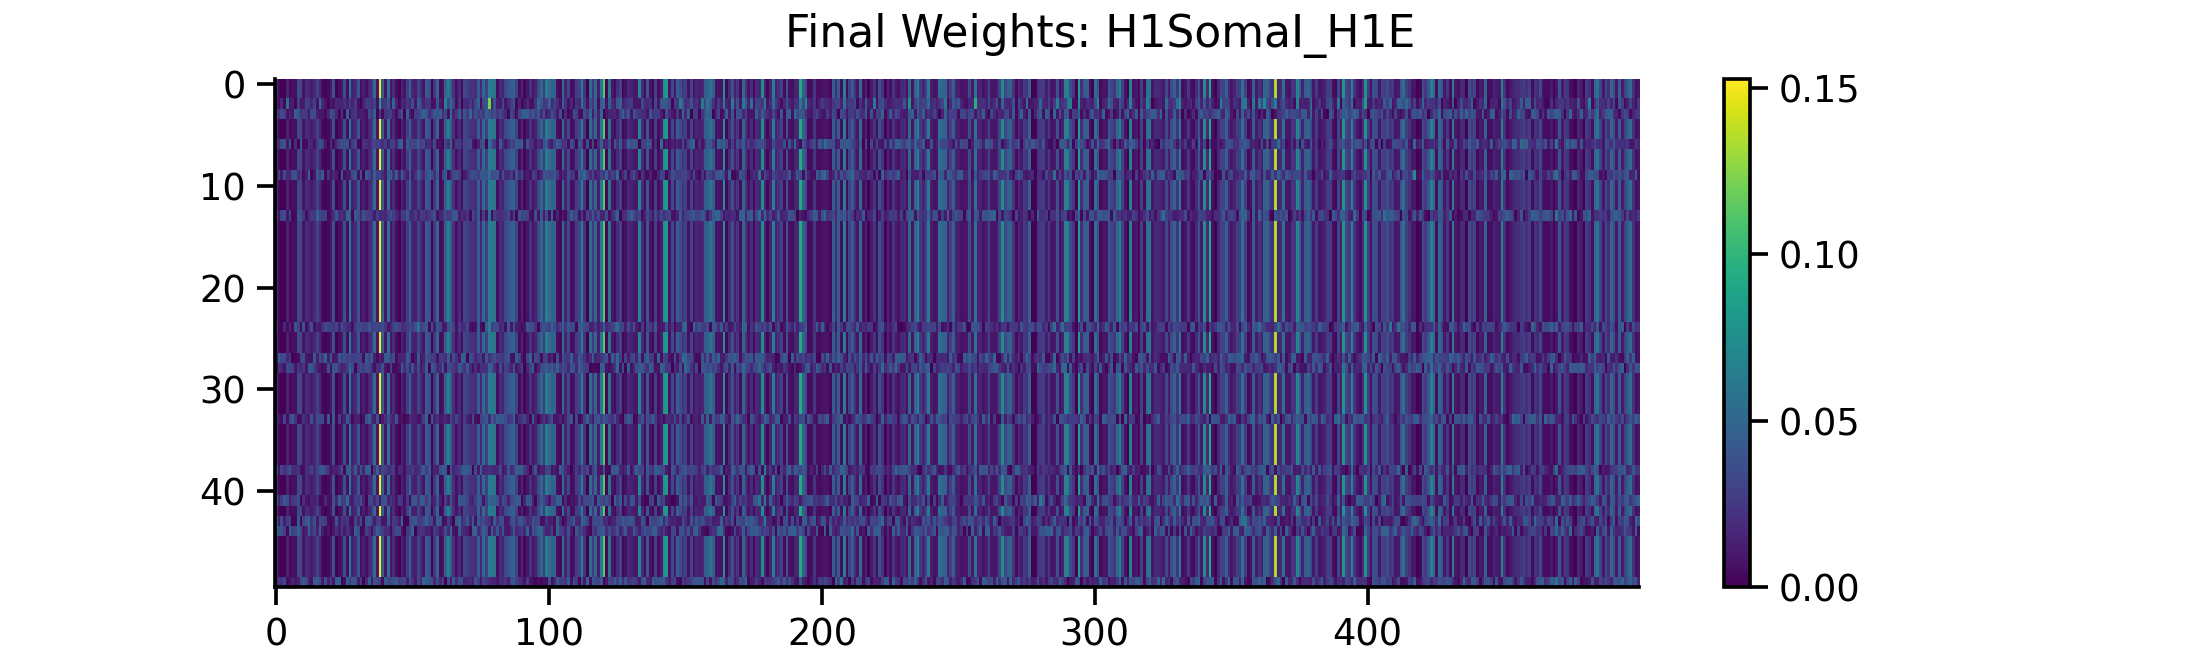

<IPython.core.display.Javascript object>


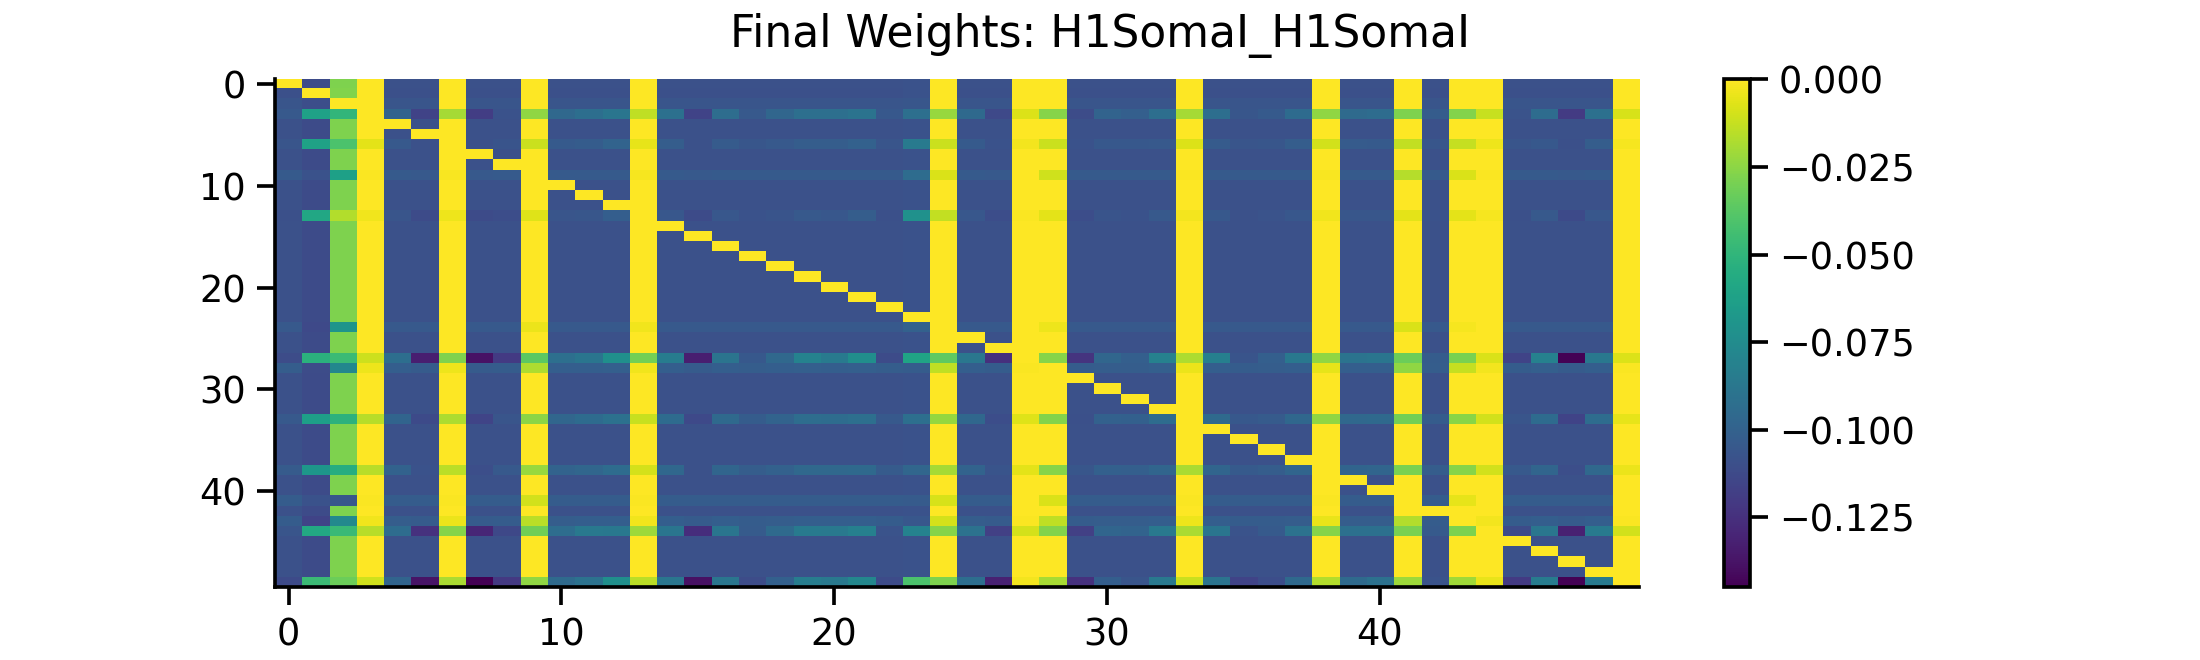

<IPython.core.display.Javascript object>


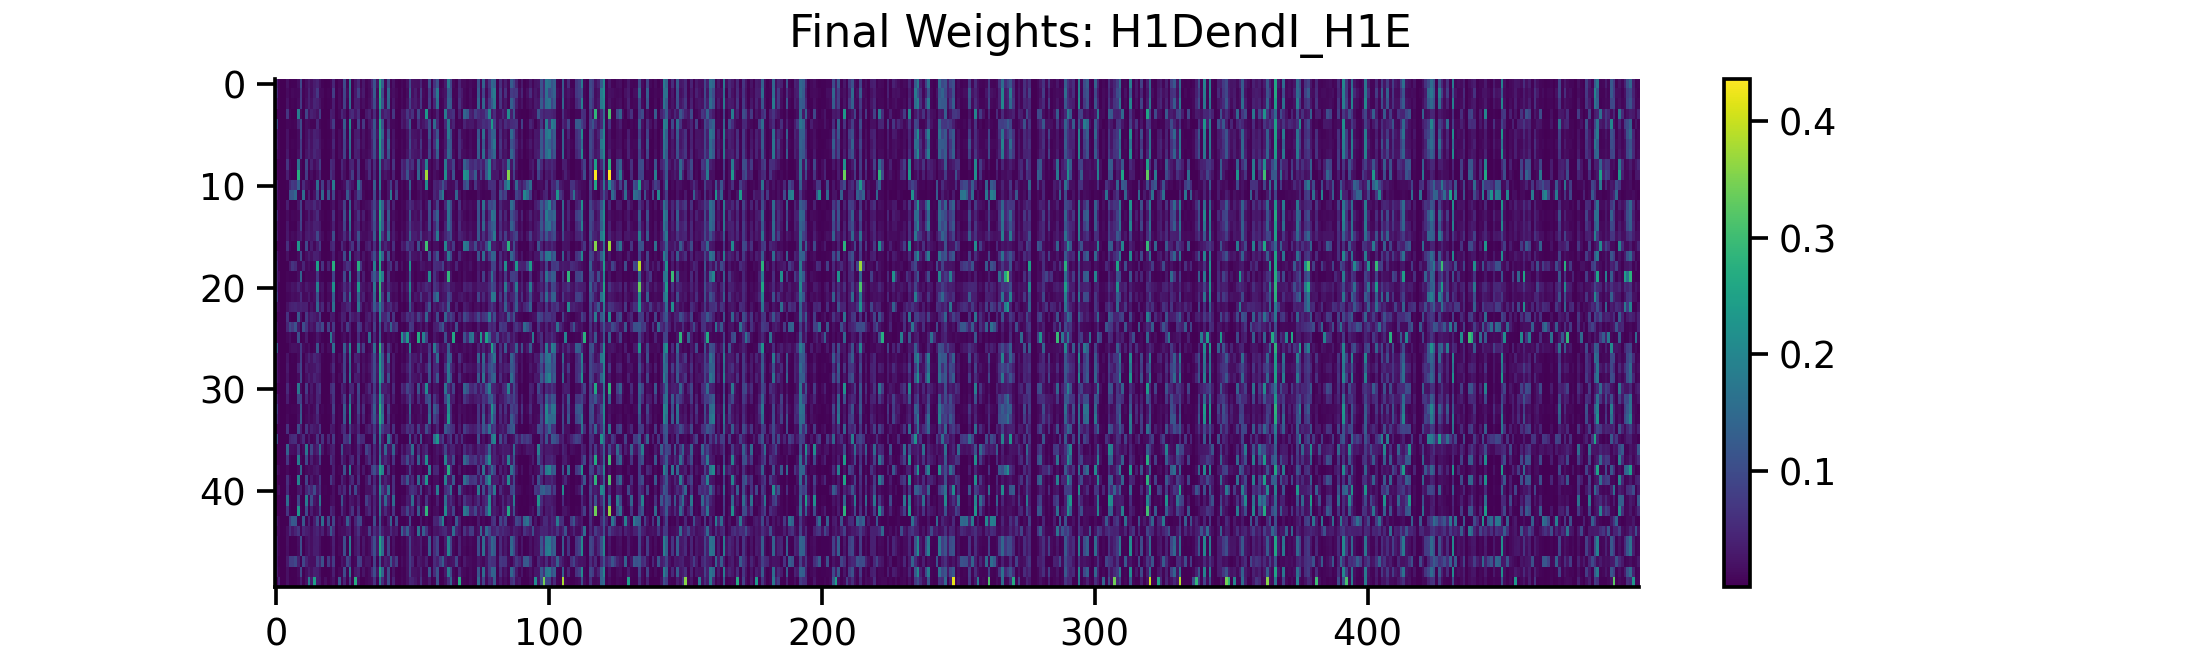

<IPython.core.display.Javascript object>


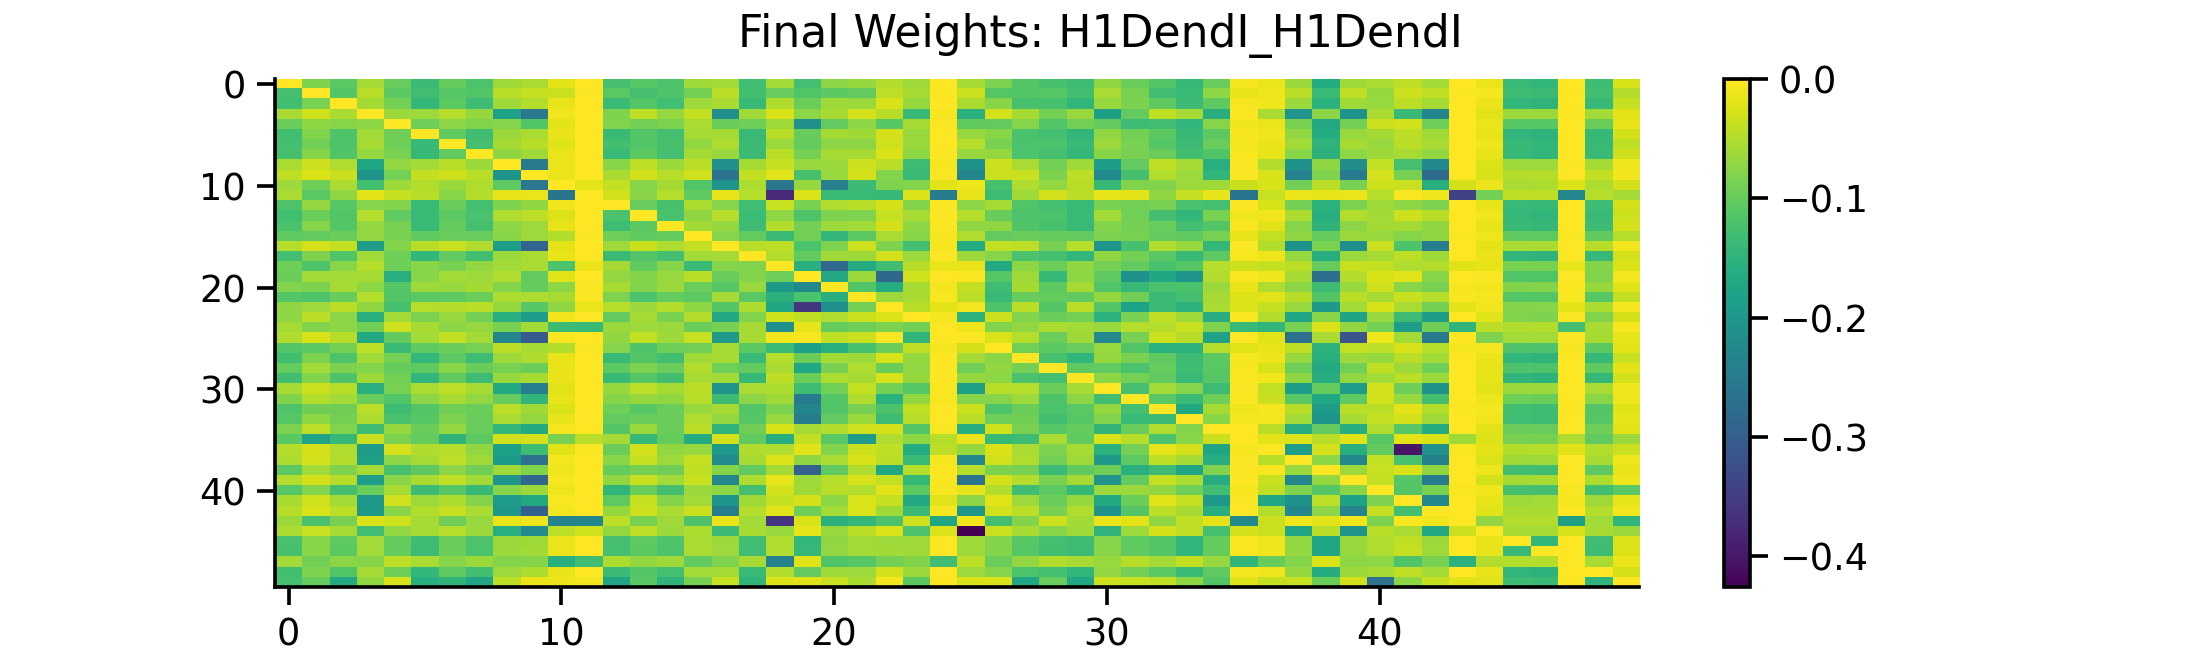

<IPython.core.display.Javascript object>


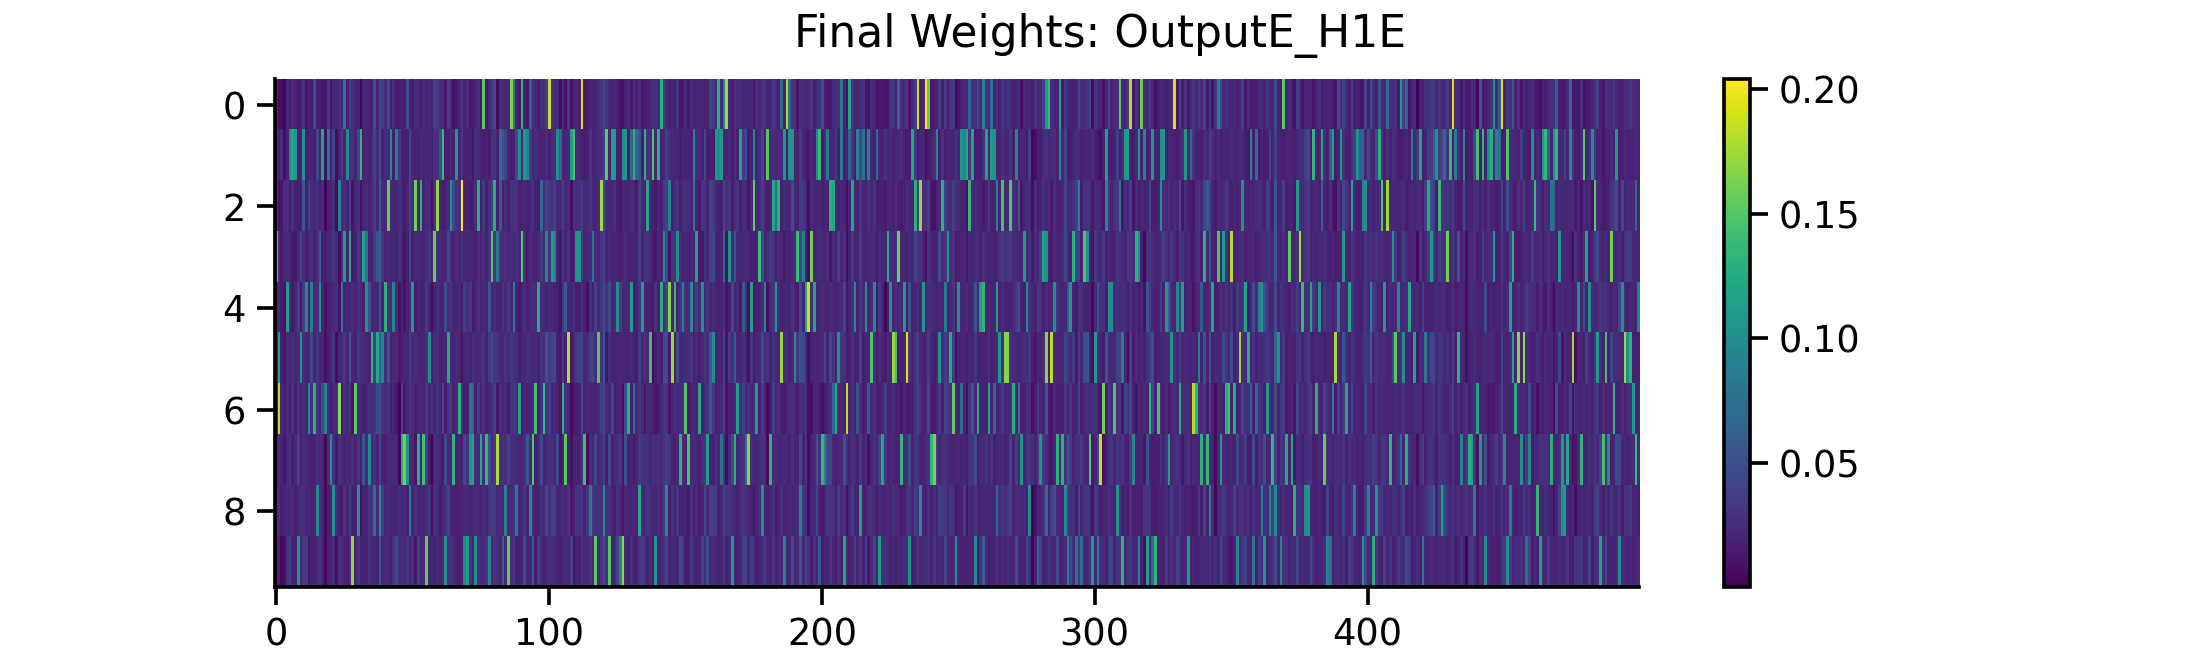

<IPython.core.display.Javascript object>


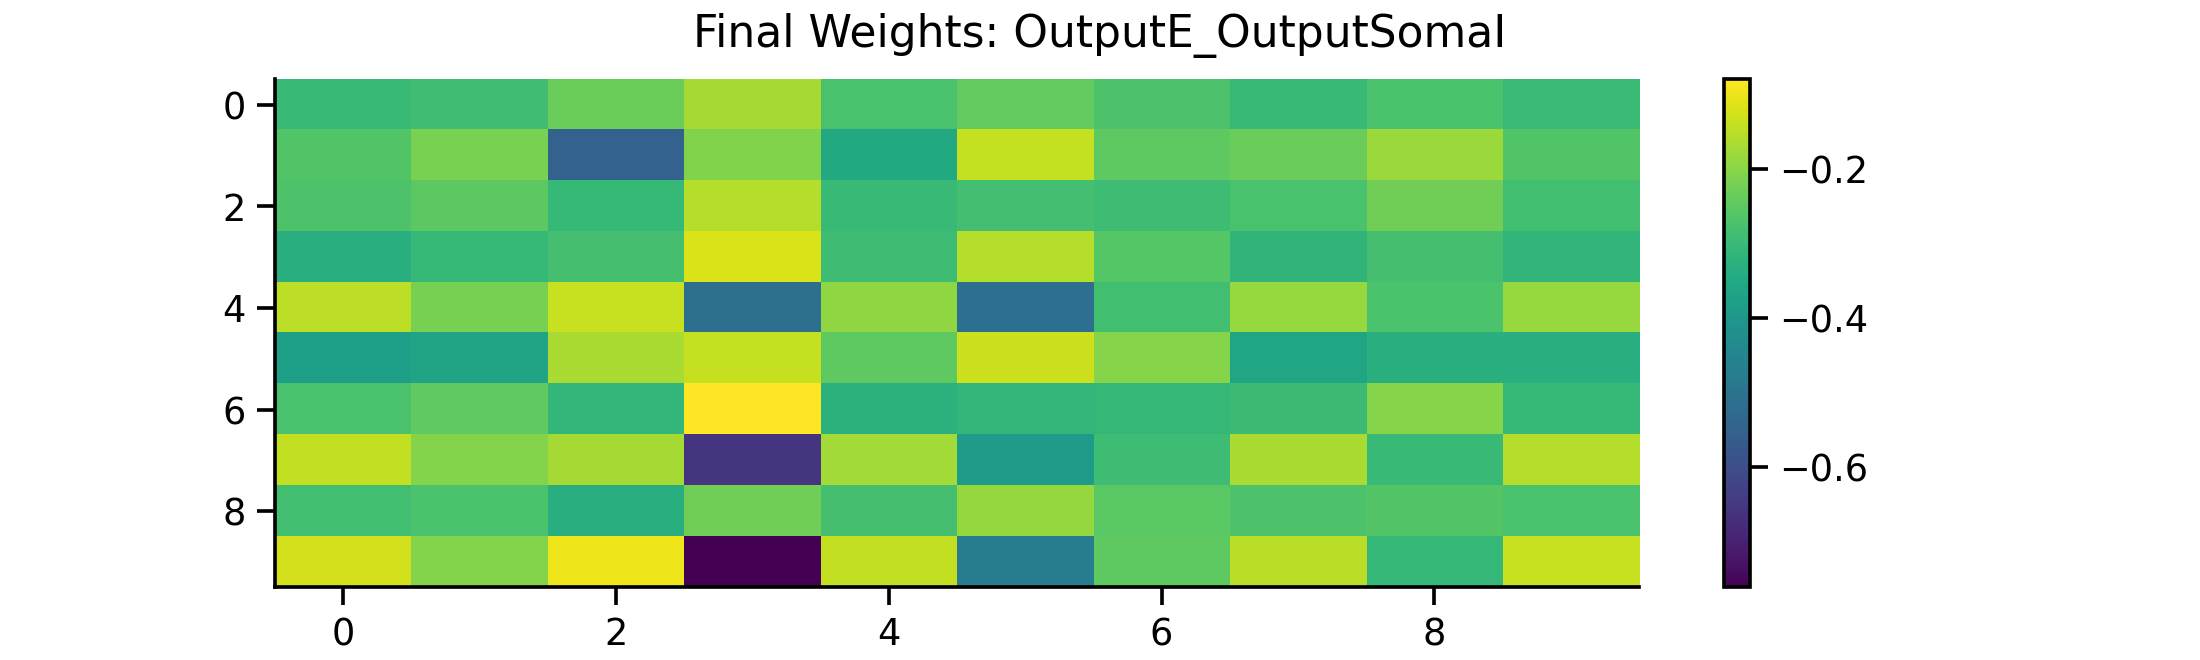

<IPython.core.display.Javascript object>


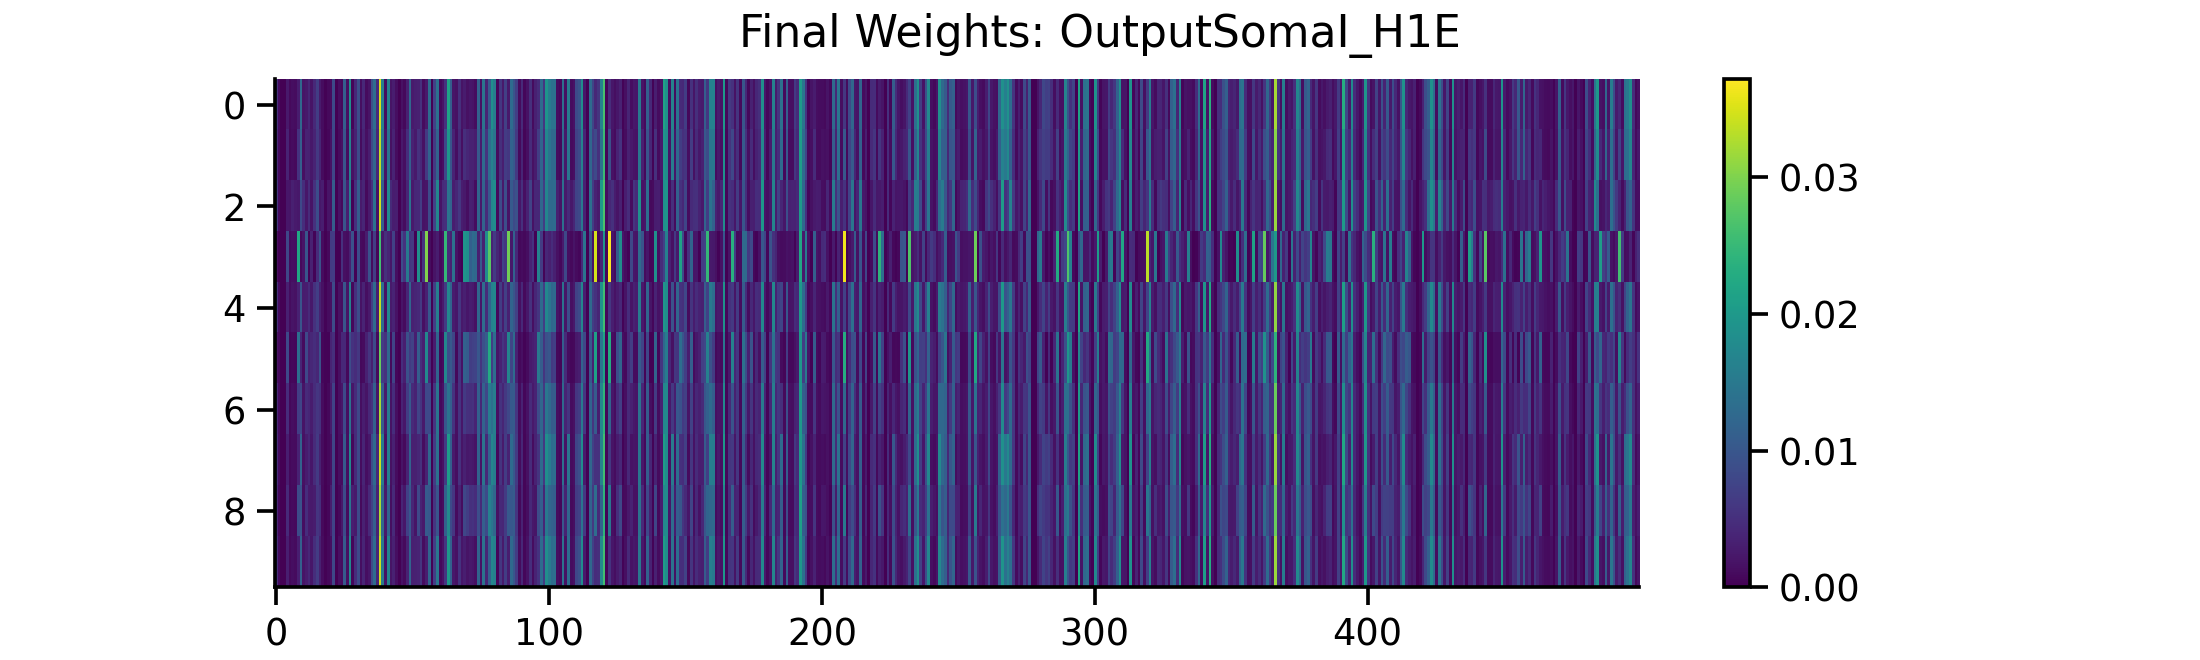

<IPython.core.display.Javascript object>


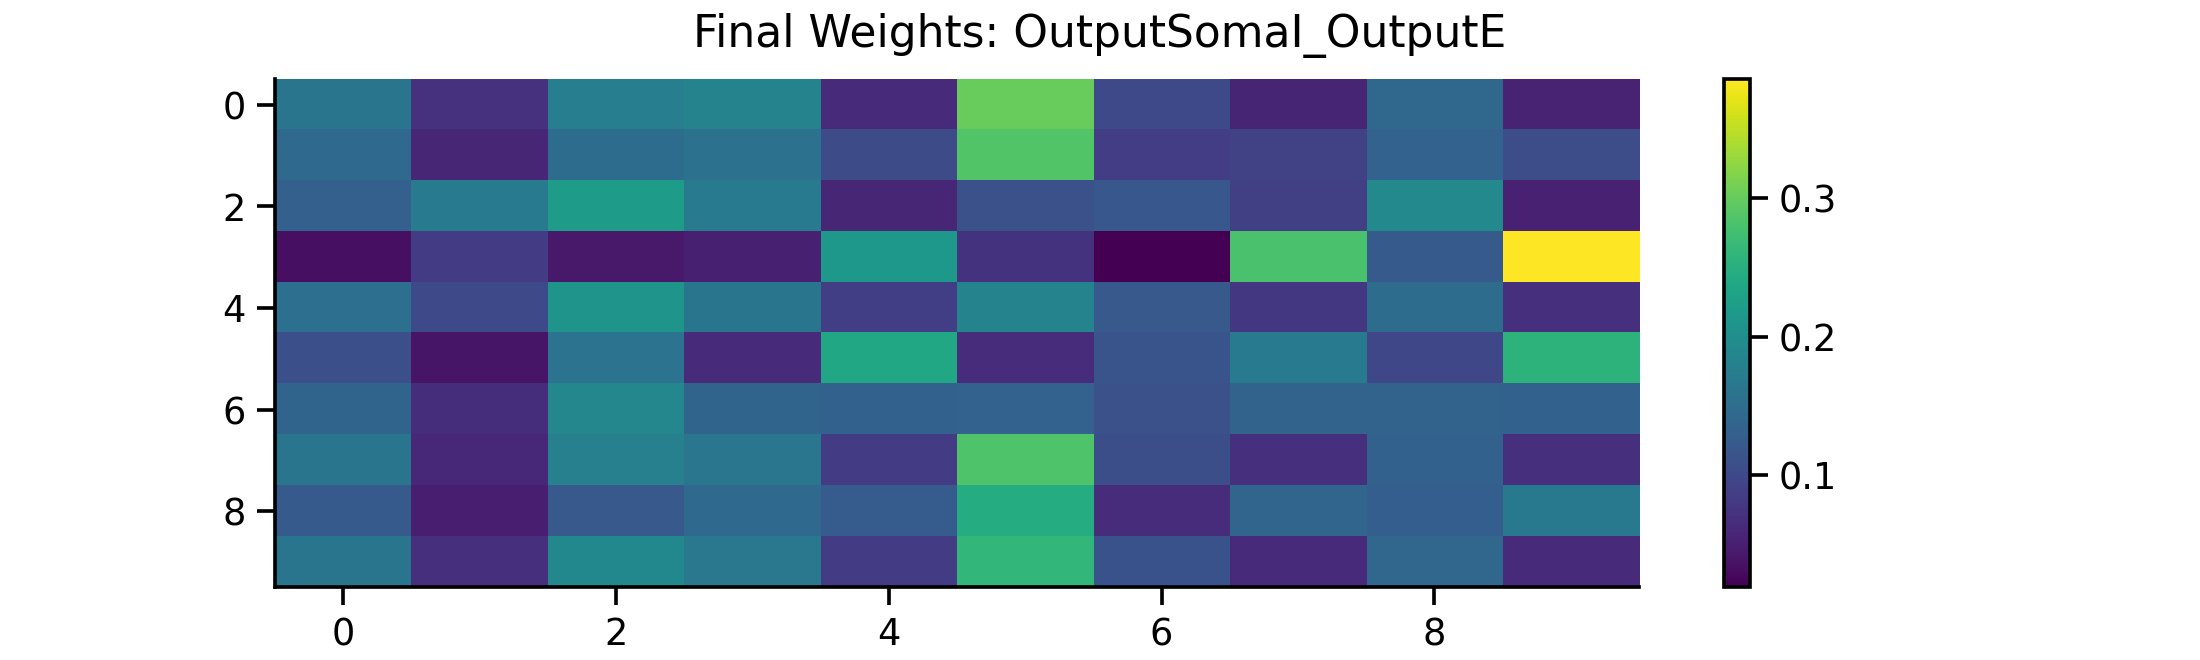

<IPython.core.display.Javascript object>


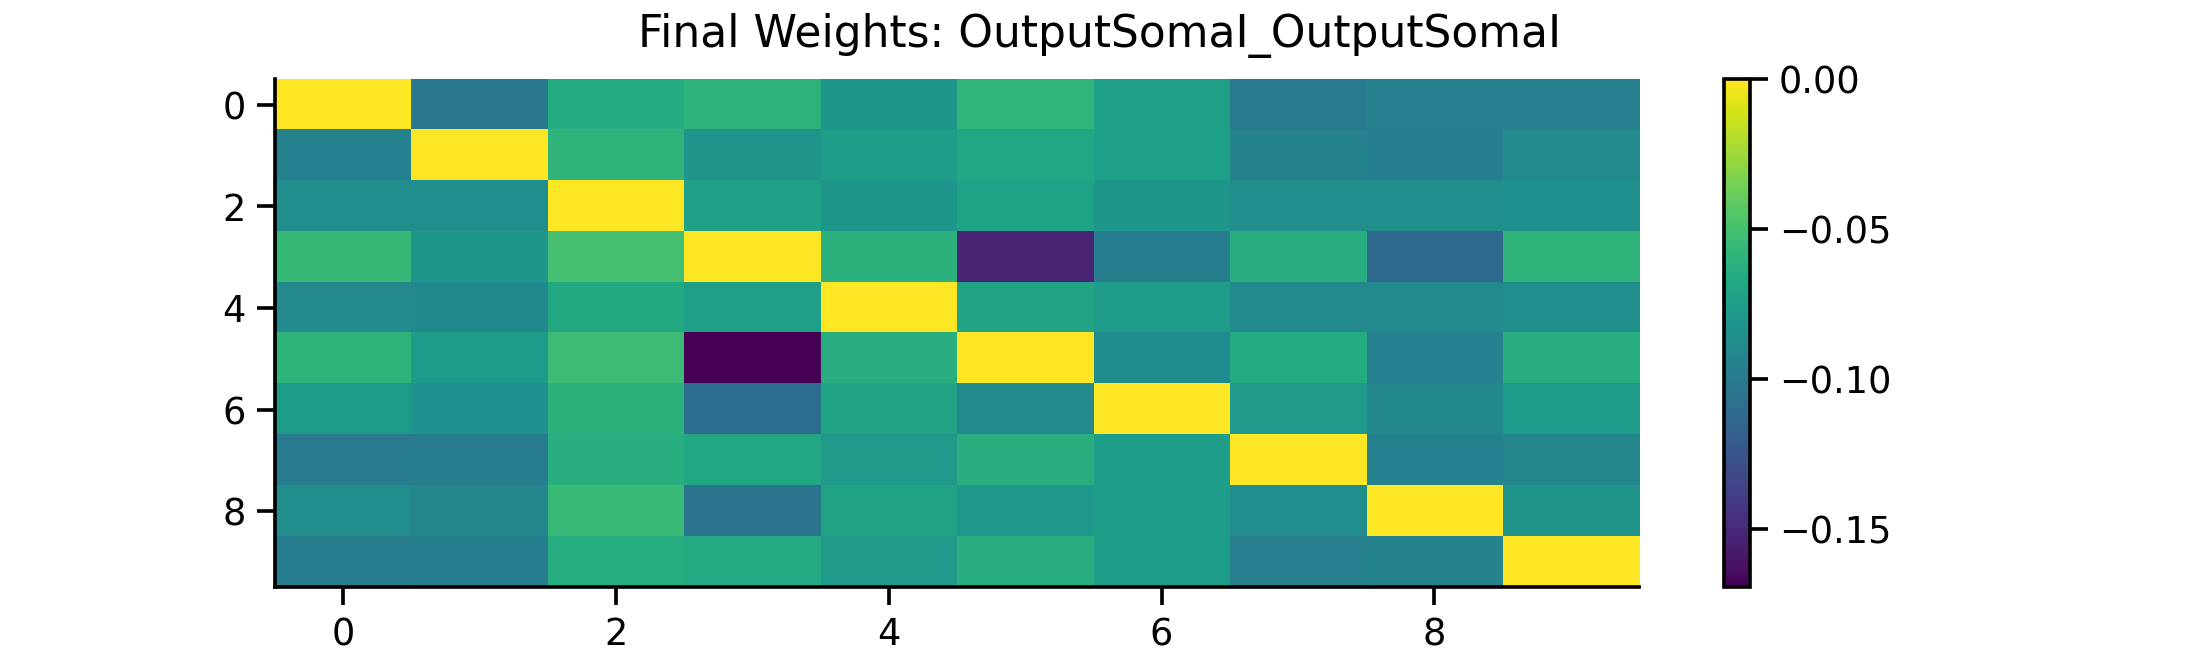

<IPython.core.display.Javascript object>


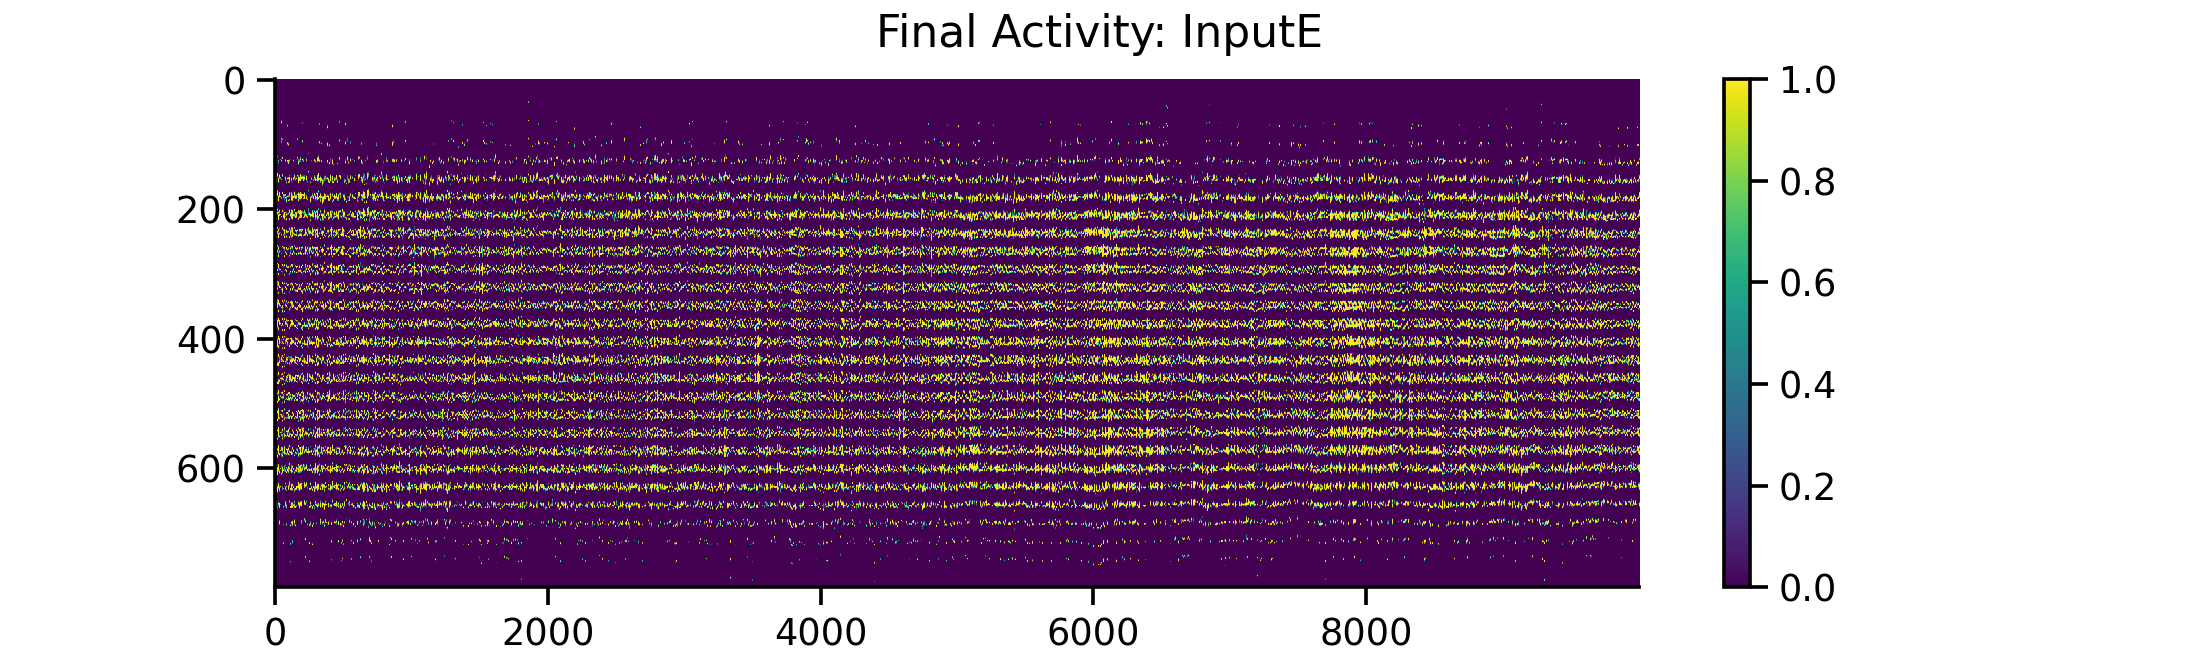

<IPython.core.display.Javascript object>


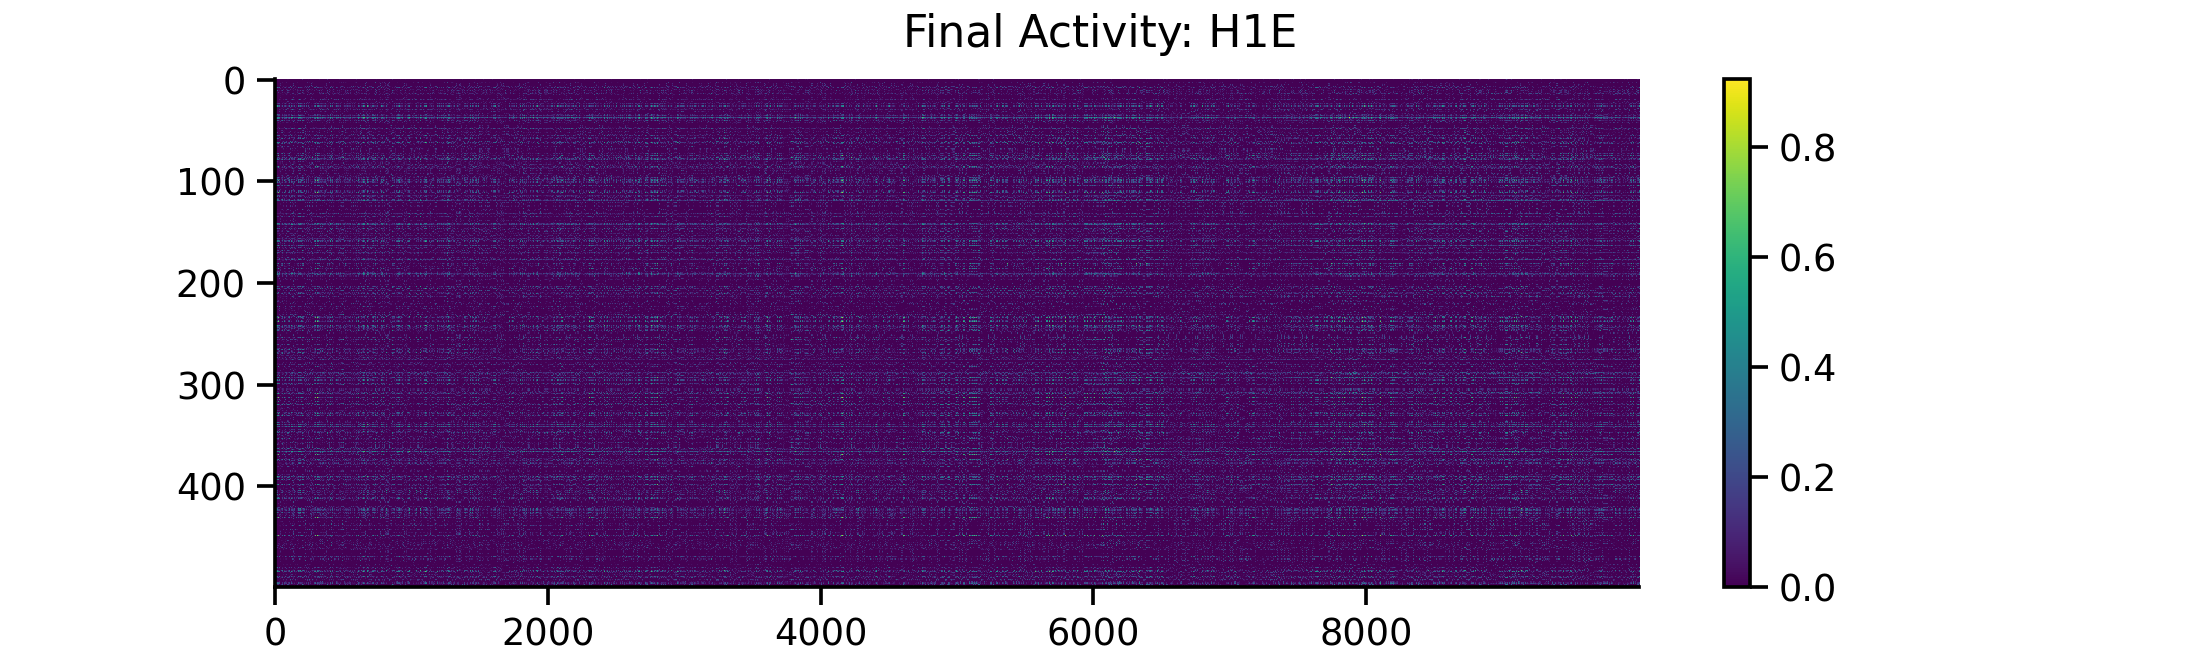

<IPython.core.display.Javascript object>


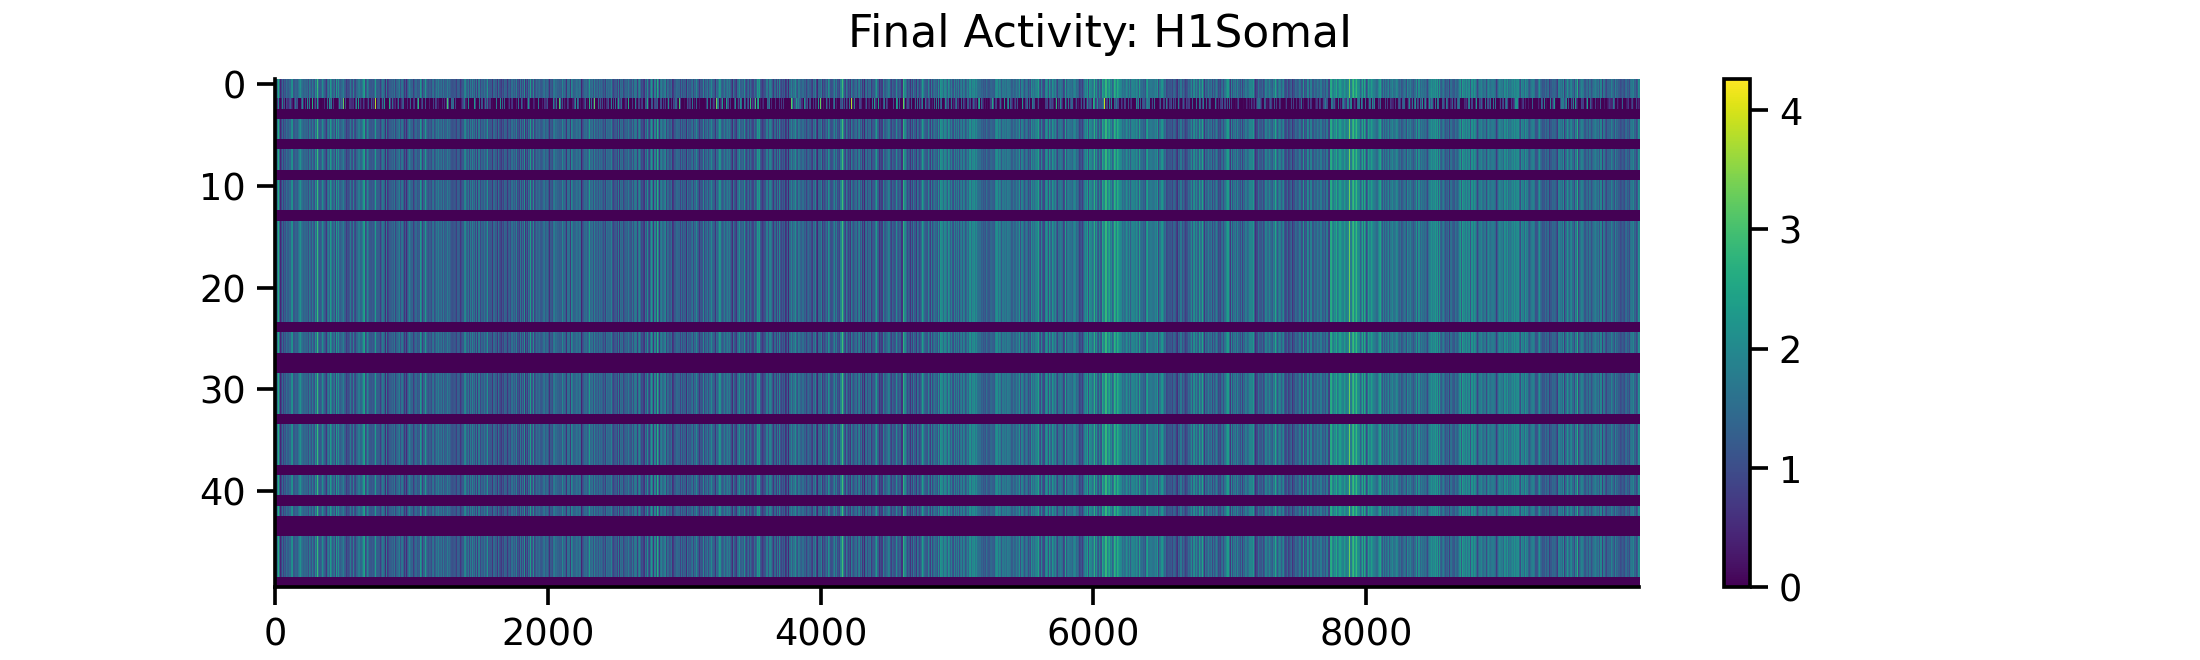

/var/folders/1v/63_09y215ml8k3bkh1my_dfw0000gn/T/ipykernel_95660/2199023725.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


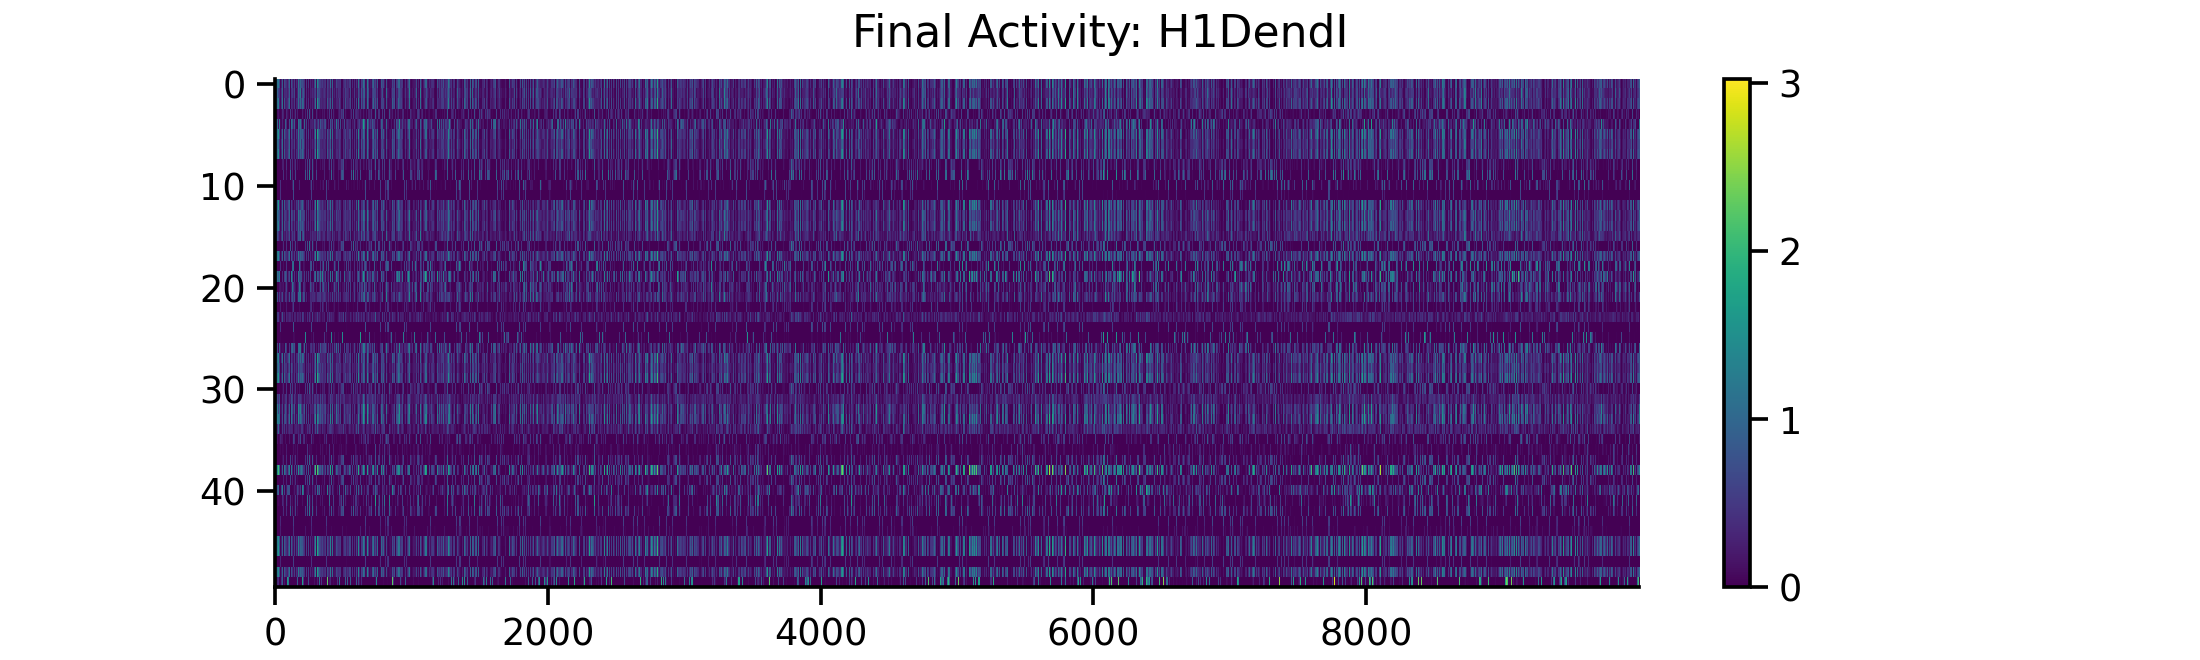

<IPython.core.display.Javascript object>


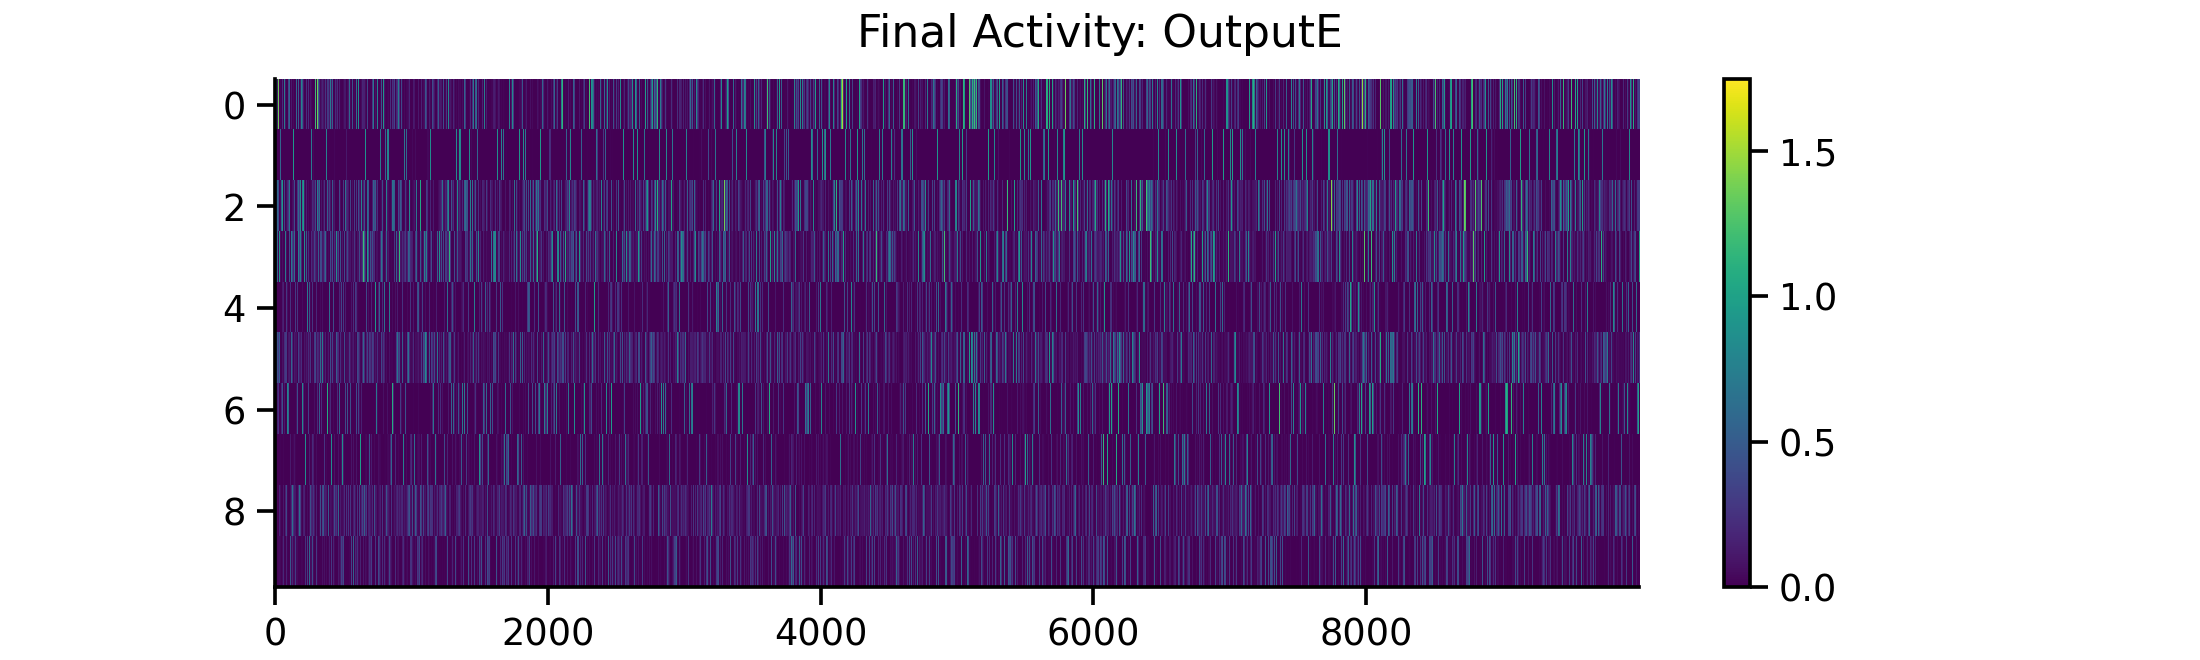

<IPython.core.display.Javascript object>


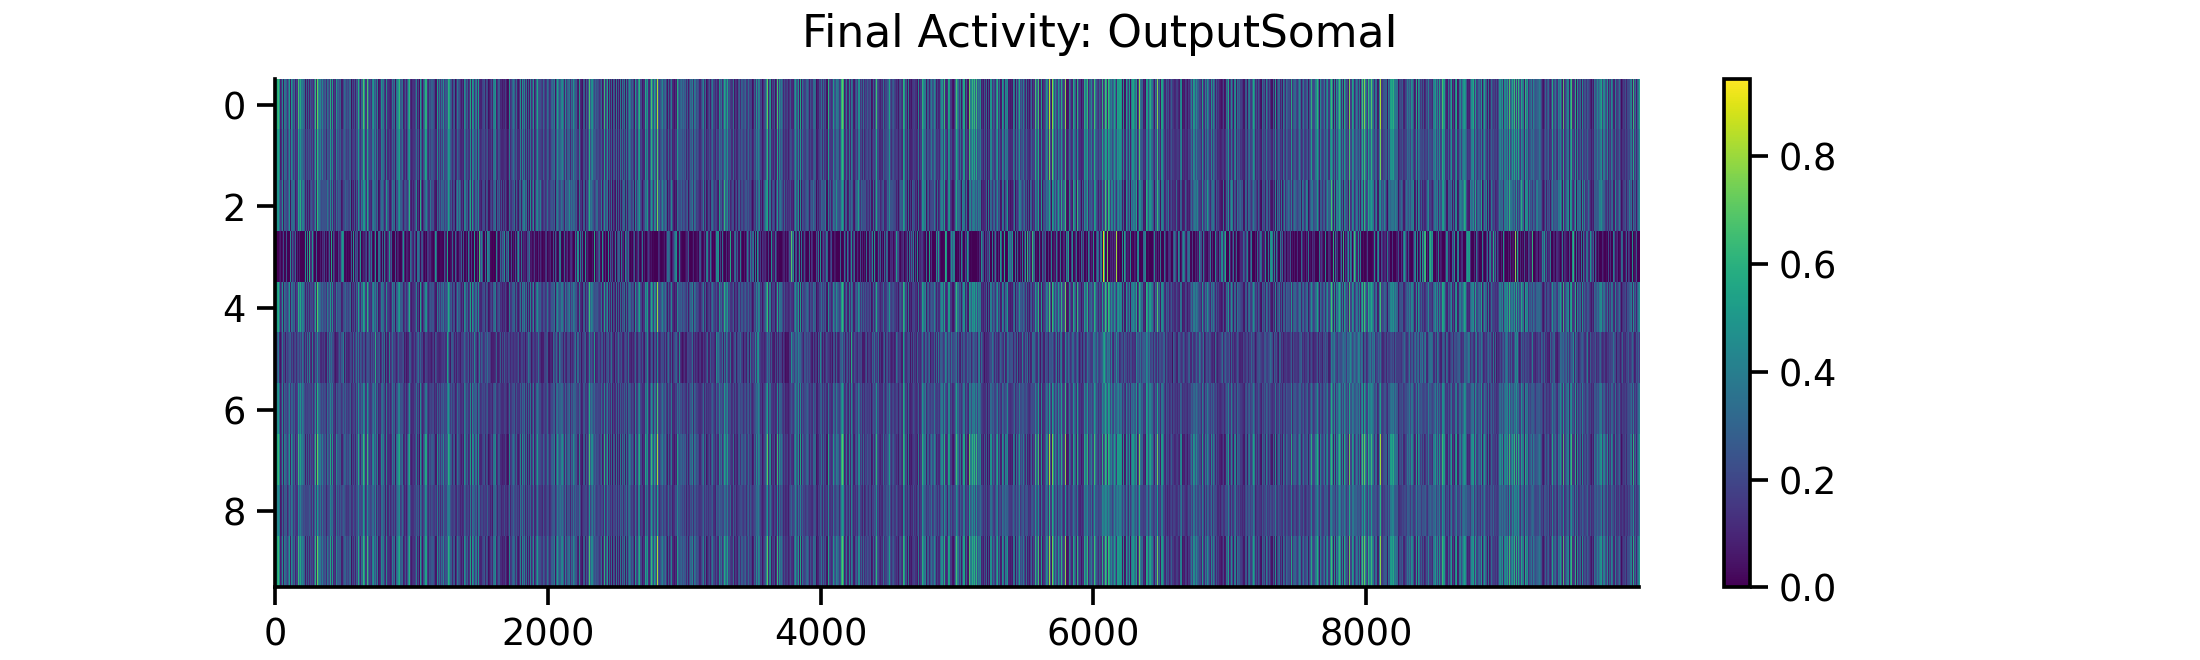

In [8]:
data_generator.manual_seed(data_seed)
# diagnose_mnist_network(btsp_network_F5, test_dataloader, full_train_dataloader, val_dataloader, supervised=True, store_history=True, store_params=True)
diagnose_mnist_network(btsp_network_F5, test_dataloader, train_sub_dataloader, val_dataloader, supervised=True, store_history=True, store_params=True)
# diagnose_mnist_network(btsp_network_F5, test_dataloader, debug_dataloader, val_dataloader, supervised=True, store_history=True, store_params=True)

<IPython.core.display.Javascript object>


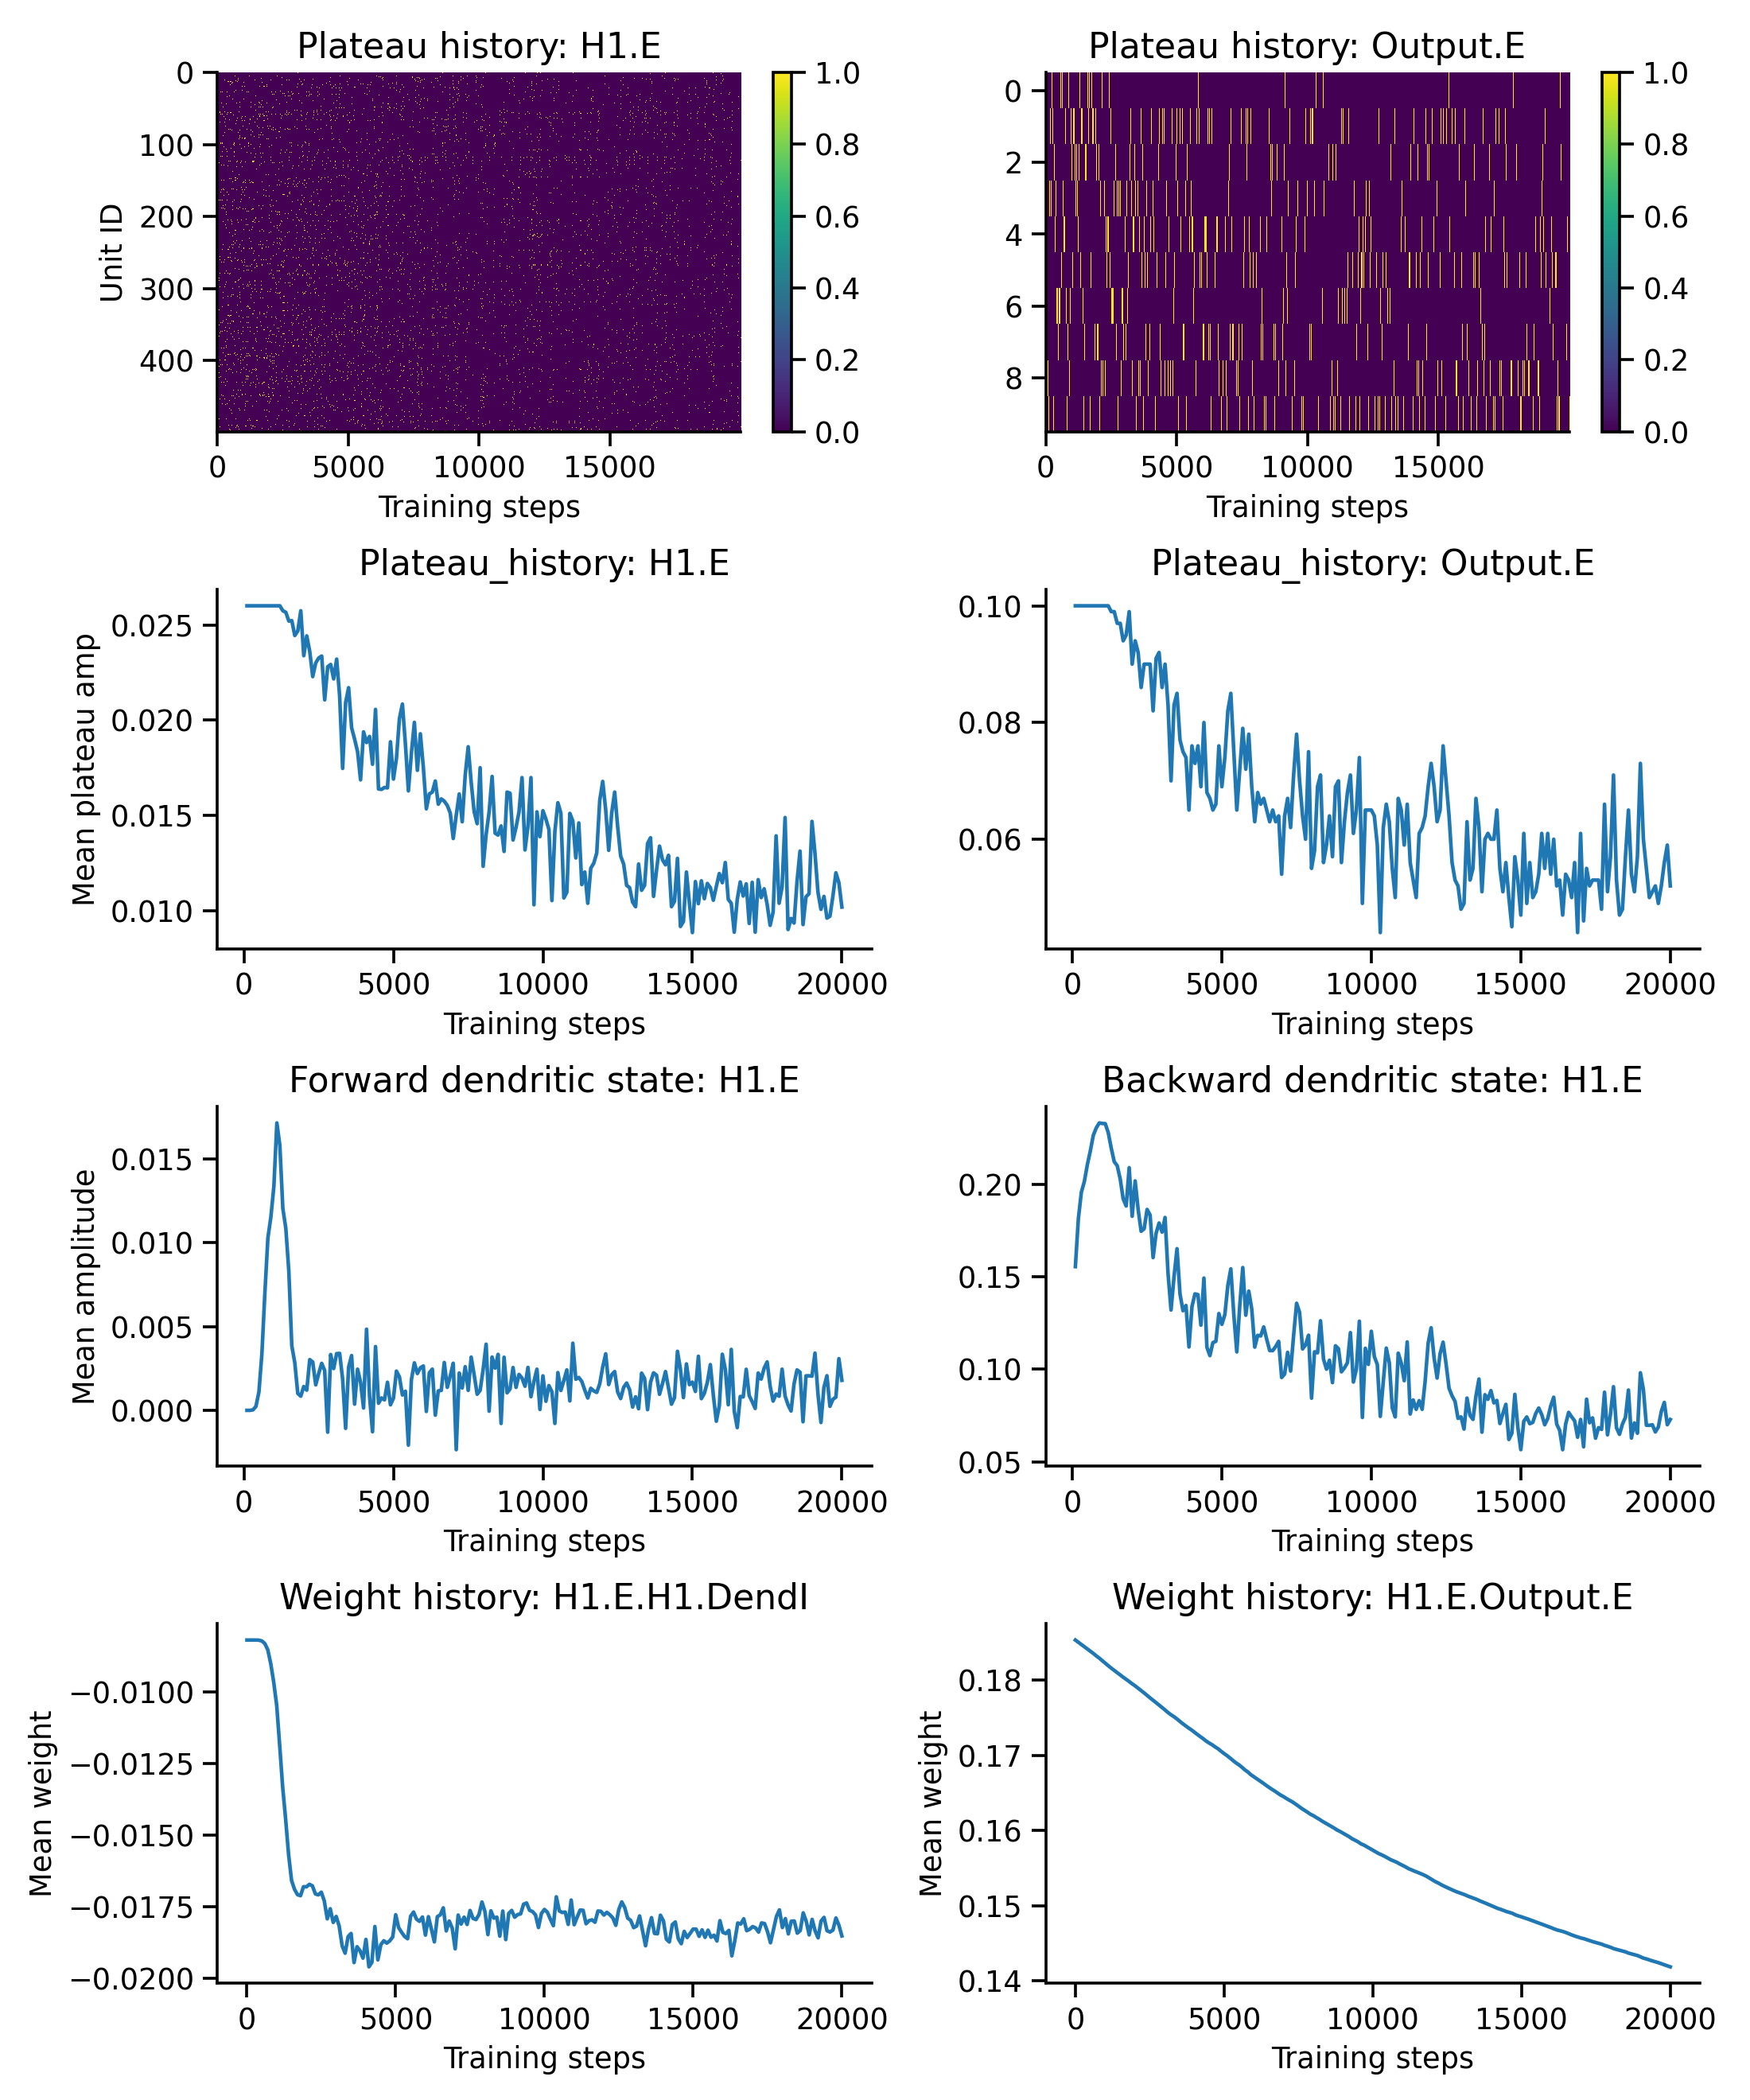

In [9]:
analyze_BTSP_intermediates(btsp_network_F5)

### Gjorgjieva_Hebb

In [ ]:
network_config = ut.read_from_yaml('../optimize/data/20230103_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_B.yaml') 
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

gjorgjieva_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
data_generator.manual_seed(data_seed)
diagnose_mnist_network(gjorgjieva_network, test_dataloader, train_sub_dataloader, val_dataloader, supervised=False)